In [2]:
!pip install xgboost

  Using cached xgboost-2.1.1-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-2.1.1-py3-none-win_amd64.whl (124.9 MB)


In [3]:
pip install shap lime

  Using cached lime-0.2.0.1.tar.gz (275 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ----------------------- ---------------- 1.6/2.7 MB 7.6 MB/s eta 0:00:01
   ---------------------------------------- 2.7/2.7 MB 7.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/28.1 MB ? eta -:--:--
   -- ------------------------------------- 2.1/28.1 MB 13.0 MB/s eta 0:00:02
   ------ --------------------------------- 4.7/28.1 MB 12.4 MB/s eta 0:00:02
   ----------- ---------------------------- 7.9/28.1 MB 13.5 MB/s eta 0:00:02
   ------------- -------------------------- 9.7/28.1 MB 13.4 MB/s eta 0:00:02
   ------------------ --------------------- 13.1/28.1 MB 12.6 MB/s eta 0:00:02
   ----------------------- ---------------- 16.8/28.1 MB 1

In [4]:
!pip install alibi

  Using cached alibi-0.9.6-py3-none-any.whl.metadata (22 kB)
  Using cached blis-0.7.11-cp312-cp312-win_amd64.whl.metadata (7.6 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached transformers-4.44.2-py3-none-any.whl.metadata (43 kB)
  Using cached spacy_legacy-3.0.12-py2.py3-none-any.whl.metadata (2.8 kB)
  Using cached spacy_loggers-1.0.5-py3-none-any.whl.metadata (23 kB)
  Using cached murmurhash-1.0.10-cp312-cp312-win_amd64.whl.metadata (2.0 kB)
  Using cached cymem-2.0.8-cp312-cp312-win_amd64.whl.metadata (8.6 kB)
  Using cached preshed-3.0.9-cp312-cp312-win_amd64.whl.metadata (2.2 kB)
  Using cached thinc-8.2.5-cp312-cp312-win_amd64.whl.metadata (15 kB)
  Using cached wasabi-1.1.3-py3-none-any.whl.metadata (28 kB)
  Using cached srsly-2.4.8-cp312-cp312-win_amd64.whl.metadata (20 kB)
  Using cached catalogue-2.0.10-py3-none-any.whl.metadata (14 kB)
  Using cached weasel-0.4.1-py3-none-any.whl.metadata (4.6 kB)
  Using cached typer-0.12.5-py3-none-any.whl

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
import joblib

import shap
from lime import lime_tabular
from lime.lime_tabular import LimeTabularExplainer
from alibi.explainers import AnchorTabular

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

import warnings
warnings.filterwarnings('ignore')

**STEP 1: LOADING DATASET**

In [2]:
df = pd.read_csv('Mobile_Payment_Fraud_Detection_Dataset.csv')

**STEP 2: PRELIMINARY DATAFRAME OPERATIONS**

In [3]:
df.shape

(6362620, 11)

In [4]:
df.head()

step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36  M1979787155             0.0             0.0        0               0
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72  M2044282225             0.0             0.0        0               0
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   C553264065             0.0             0.0        1               0
3     1  CASH_OUT    181.00   C840083671          181.0            0.00    C38997010         21182.0             0.0        1               0
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86  M1230701703             0.0             0.0        0               0

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
df.describe()

# Insights: remove isFlaggedFraud (not meaningful)

step        amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest       isFraud  isFlaggedFraud
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06    6.362620e+06    6.362620e+06  6.362620e+06    6.362620e+06
mean   2.433972e+02  1.798619e+05   8.338831e+05    8.551137e+05    1.100702e+06    1.224996e+06  1.290820e-03    2.514687e-06
std    1.423320e+02  6.038582e+05   2.888243e+06    2.924049e+06    3.399180e+06    3.674129e+06  3.590480e-02    1.585775e-03
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00    0.000000e+00    0.000000e+00  0.000000e+00    0.000000e+00
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e+00    0.000000e+00    0.000000e+00  0.000000e+00    0.000000e+00
50%    2.390000e+02  7.487194e+04   1.420800e+04    0.000000e+00    1.327057e+05    2.146614e+05  0.000000e+00    0.000000e+00
75%    3.350000e+02  2.087215e+05   1.073152e+05    1.442584e+05    9.430367e+05    1.111909e+06  0.000000e+00    0.000000e+00
max    7.430000e+02  9.244552e+07   5.958504e+07    4.958504e+07    3.560159e+08    3.561793e+08  1.000000e+00    1.000000e+00

In [7]:
df.describe(include='object')

# Insights: remove nameOrig & nameDest (not meaningful)

type     nameOrig     nameDest
count    6362620      6362620      6362620
unique         5      6353307      2722362
top     CASH_OUT  C1902386530  C1286084959
freq     2237500            3          113

In [8]:
df = df.rename(columns={'oldbalanceOrg': 'oldbalanceOrig'})
df.head()

step      type    amount     nameOrig  oldbalanceOrig  newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud
0     1   PAYMENT   9839.64  C1231006815        170136.0       160296.36  M1979787155             0.0             0.0        0               0
1     1   PAYMENT   1864.28  C1666544295         21249.0        19384.72  M2044282225             0.0             0.0        0               0
2     1  TRANSFER    181.00  C1305486145           181.0            0.00   C553264065             0.0             0.0        1               0
3     1  CASH_OUT    181.00   C840083671           181.0            0.00    C38997010         21182.0             0.0        1               0
4     1   PAYMENT  11668.14  C2048537720         41554.0        29885.86  M1230701703             0.0             0.0        0               0

**STEP 3: EXPLORATORY DATA ANALYSIS**

In [9]:
df.isnull().sum()

# Insights: No missing values found

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrig    0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

**EDA - Categorical variables (IV)**

[Text(0, 0, '2237500'),
 Text(0, 0, '2151495'),
 Text(0, 0, '1399284'),
 Text(0, 0, '532909'),
 Text(0, 0, '41432')]

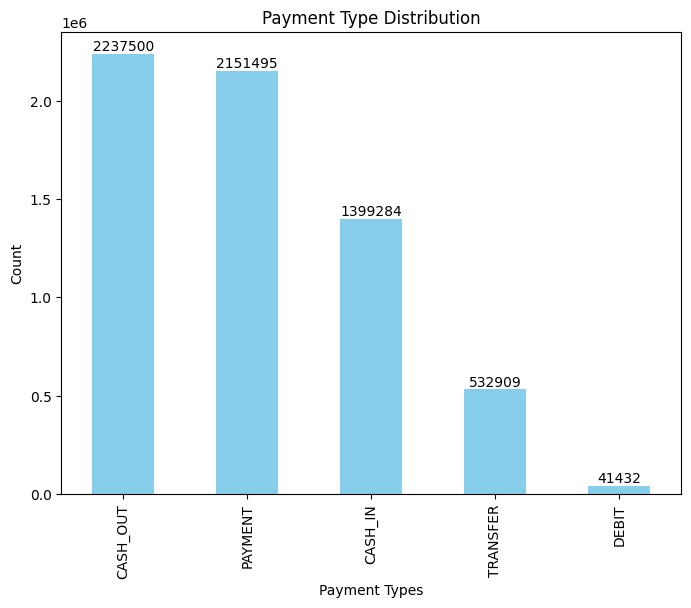

In [15]:
type_count = df['type'].value_counts()
plt.figure(figsize=(8, 6))
ax_type = type_count.plot(kind='bar', color='skyblue')
plt.xlabel('Payment Types')
plt.ylabel('Count')
plt.title('Payment Type Distribution')
ax_type.bar_label(ax_type.containers[0], fontsize=10, color='black', labels=type_count.values)

<Figure size 800x600 with 0 Axes>

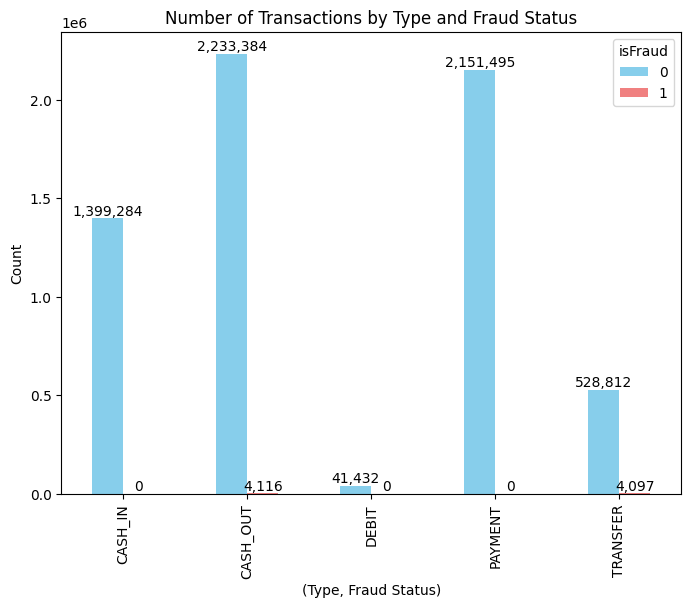

In [16]:
plt.figure(figsize=(8, 6))
ax_type2 = df.groupby(['type', 'isFraud']).size().unstack(fill_value=0).plot(kind='bar', figsize=(8, 6), color=['skyblue', 'lightcoral'])
plt.title("Number of Transactions by Type and Fraud Status")
plt.xlabel("(Type, Fraud Status)")
plt.ylabel("Count")
for p in ax_type2.patches:
    ax_type2.annotate(str(format(int(p.get_height()), ',d')), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')
plt.legend(title='isFraud', loc='upper right', labels=['0', '1'])
plt.show()

# Insights: Fraud transactions only occur in cash out and transfer transaction types

In [17]:
fraud = df[df["isFraud"] == 1]

fraudtransfer = fraud[fraud["type"] == "TRANSFER"]
fraudcashout = fraud[fraud["type"] == "CASH_OUT"]

fraudtransfer.nameDest.isin(fraudcashout.nameOrig).any()

# Insights: In the case of fraudulent transactions, the recipient accounts of transfer transactions are not at all used to cashout

False

In [18]:
fraudtransfer['nameDest'].value_counts()

nameDest
C553264065     1
C988859148     1
C1287650869    1
C922180689     1
C131895413     1
              ..
C776246900     1
C1234144009    1
C571016162     1
C1381364691    1
C2080388513    1
Name: count, Length: 4097, dtype: int64

In [19]:
fraudcashout['nameOrig'].value_counts()

# Insights: The origin and recipient names are therefore meaningless for modeling purposes and are removed

nameOrig
C840083671     1
C1055498407    1
C1886113938    1
C520336445     1
C463684846     1
              ..
C1641368956    1
C2120940829    1
C992121519     1
C1663597987    1
C1280323807    1
Name: count, Length: 4116, dtype: int64

<Figure size 800x600 with 0 Axes>

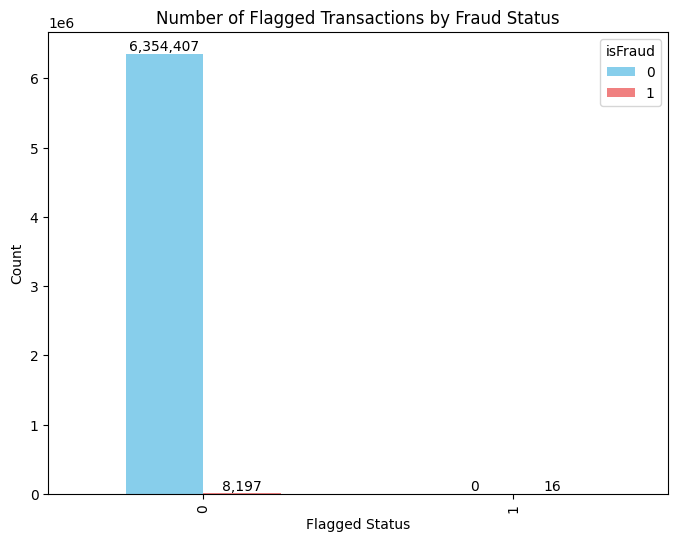

In [20]:
plt.figure(figsize=(8, 6))
ax_isFlaggedFraud = df.groupby(['isFlaggedFraud', 'isFraud']).size().unstack(fill_value=0).plot(kind='bar', figsize=(8, 6), color=['skyblue', 'lightcoral'])
plt.title("Number of Flagged Transactions by Fraud Status")
plt.xlabel("Flagged Status")
plt.ylabel("Count")
for p in ax_isFlaggedFraud.patches:
    ax_isFlaggedFraud.annotate(str(format(int(p.get_height()), ',d')), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')
plt.legend(title='isFraud', loc='upper right', labels=['0', '1'])
plt.show()

# Insights: Only 16 transactions out of 8213 (8197 + 16) total fraudulent transactions are flagged as fraud

**EDA - Dependent variable**

In [21]:
unique_values_isFraud = df['isFraud'].unique()
print("Unique values for 'isFraud':", unique_values_isFraud)

Unique values for 'isFraud': [0 1]


[Text(0, 0, '6354407'), Text(0, 0, '8213')]

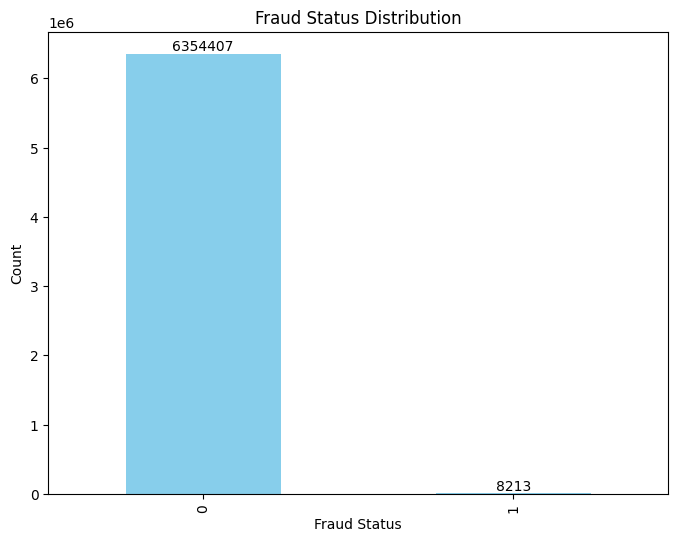

In [22]:
fraud_count = df['isFraud'].value_counts()
plt.figure(figsize=(8, 6))
ax_fraud = fraud_count.plot(kind='bar', color='skyblue')
plt.xlabel('Fraud Status')
plt.ylabel('Count')
plt.title('Fraud Status Distribution')
ax_fraud.bar_label(ax_fraud.containers[0], fontsize=10, color='black', labels=fraud_count.values)

In [23]:
fraud_count = df['isFraud'].value_counts()
fraud_count

isFraud
0    6354407
1       8213
Name: count, dtype: int64

In [24]:
fraud_percentage = df['isFraud'].value_counts(normalize=True) * 100
fraud_percentage

isFraud
0    99.870918
1     0.129082
Name: proportion, dtype: float64

**EDA - Continuous variables (IV)**

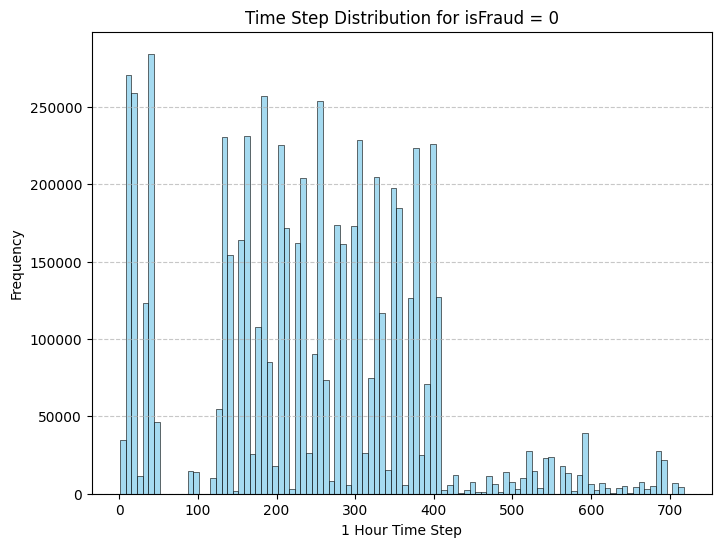

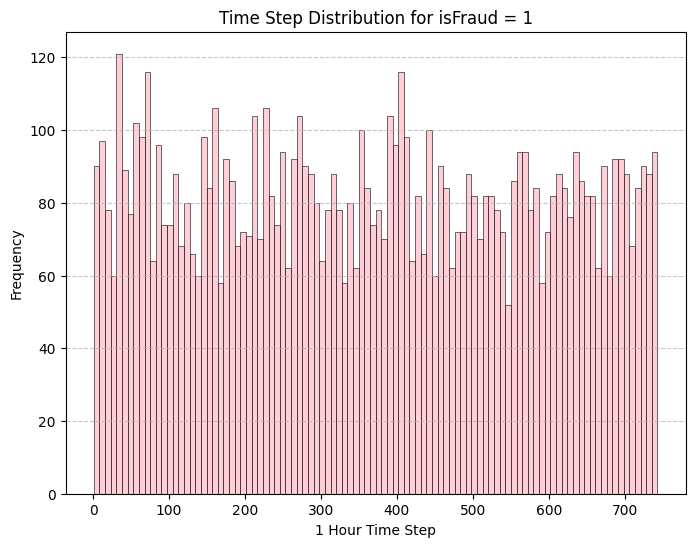

In [25]:
df_isFraud_0 = df[df['isFraud'] == 0]
plt.figure(figsize=(8, 6))
ax_step_0 = sns.histplot(data=df_isFraud_0, x='step', bins=100, color='skyblue')
plt.xlabel('1 Hour Time Step')
plt.ylabel('Frequency')
plt.title('Time Step Distribution for isFraud = 0')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


df_isFraud_1 = df[df['isFraud'] == 1]
plt.figure(figsize=(8, 6))
ax_step_1 = sns.histplot(data=df_isFraud_1, x='step', bins=100, color='pink')
plt.xlabel('1 Hour Time Step')
plt.ylabel('Frequency')
plt.title('Time Step Distribution for isFraud = 1')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Insights:
# 1. The distribution of fraudulent transactions is uniform across all time steps
# 2. Non-fraudulent transactions peak at certain time steps around the 0th and 50th time step and the 110th and 410th time step

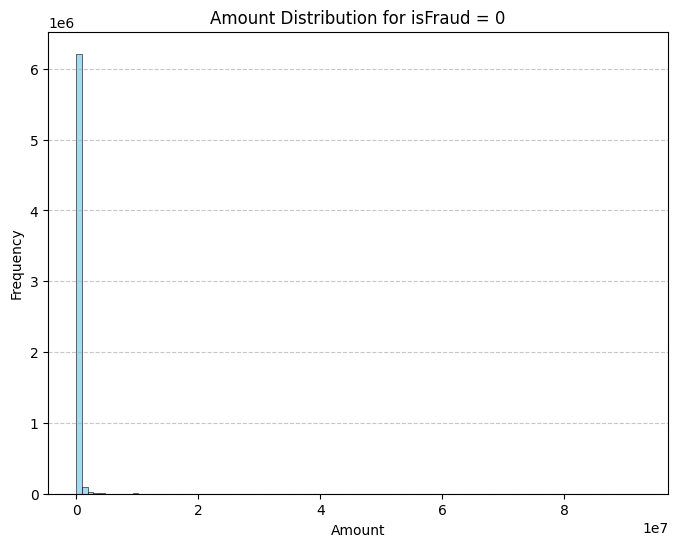

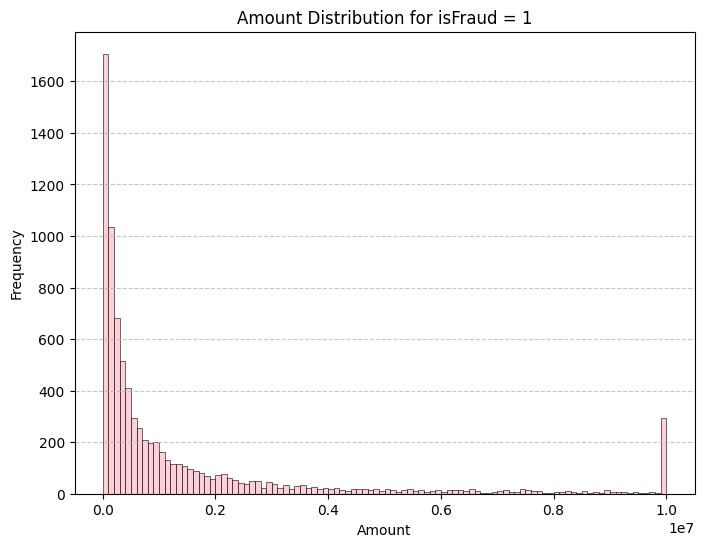

In [26]:
df_isFraud_0 = df[df['isFraud'] == 0]
plt.figure(figsize=(8, 6))
ax_amnt_0 = sns.histplot(data=df_isFraud_0, x='amount', bins=100, color='skyblue')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.title('Amount Distribution for isFraud = 0')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


df_isFraud_1 = df[df['isFraud'] == 1]
plt.figure(figsize=(8, 6))
ax_amnt_1 = sns.histplot(data=df_isFraud_1, x='amount', bins=100, color='pink')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.title('Amount Distribution for isFraud = 1')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Insights: Higher likelihood of fraud at higher transaction amounts

Text(0.5, 1.0, 'Transaction Amount by Fraud Status')

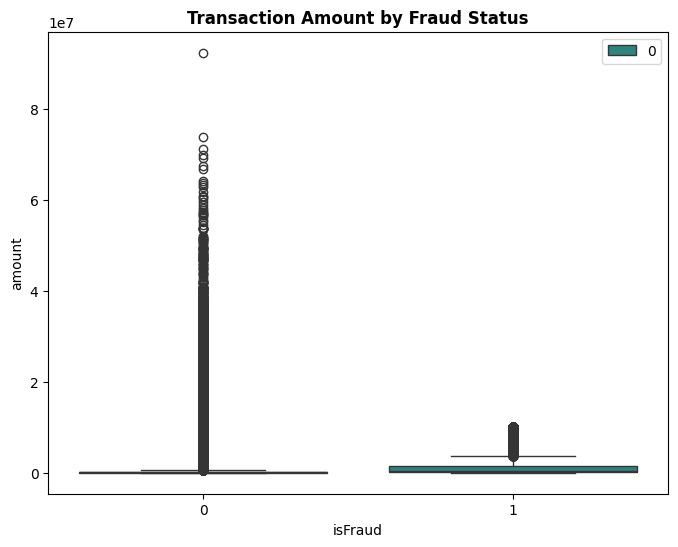

In [27]:
plt.figure(figsize=(8, 6))
sns.boxplot(x = 'isFraud', y = 'amount', data = df, palette="viridis", hue=0)
plt.title('Transaction Amount by Fraud Status', fontweight="bold", size=12)

# Insights: Median amount of fraudulent transactions is higher than genuine transactions

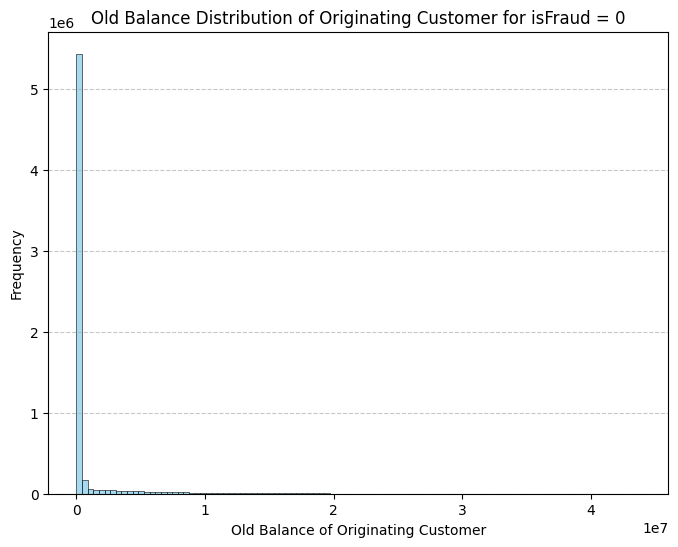

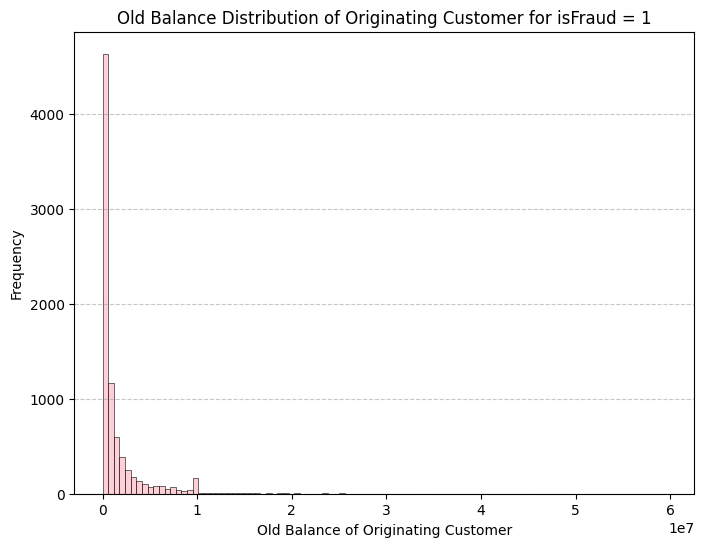

In [28]:
df_isFraud_0 = df[df['isFraud'] == 0]
plt.figure(figsize=(8, 6))
ax_oldOrig_0 = sns.histplot(data=df_isFraud_0, x='oldbalanceOrig', bins=100, color='skyblue')
plt.xlabel('Old Balance of Originating Customer')
plt.ylabel('Frequency')
plt.title('Old Balance Distribution of Originating Customer for isFraud = 0')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


df_isFraud_1 = df[df['isFraud'] == 1]
plt.figure(figsize=(8, 6))
ax_oldOrig_1 = sns.histplot(data=df_isFraud_1, x='oldbalanceOrig', bins=100, color='pink')
plt.xlabel('Old Balance of Originating Customer')
plt.ylabel('Frequency')
plt.title('Old Balance Distribution of Originating Customer for isFraud = 1')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Insights: Higher likelihood of fraud when old balance of originating customer is higher

Text(0.5, 1.0, 'Old Balance of Originating Customer by Fraud Status')

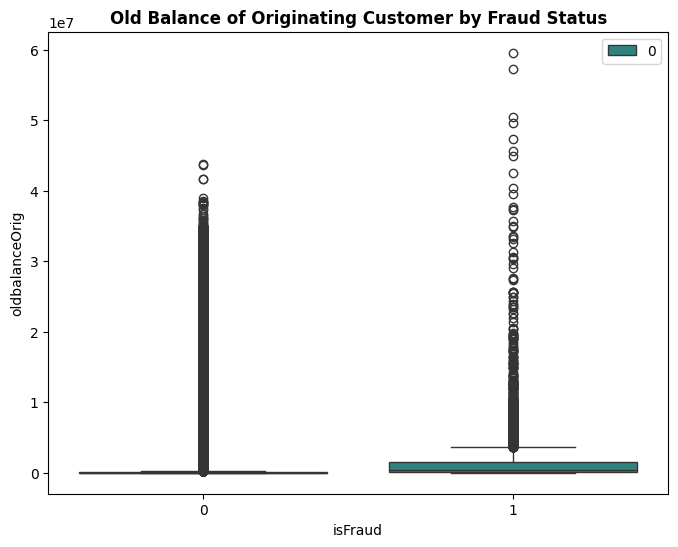

In [29]:
plt.figure(figsize=(8, 6))
sns.boxplot(x = 'isFraud', y = 'oldbalanceOrig', data = df, palette="viridis", hue=0)
plt.title('Old Balance of Originating Customer by Fraud Status', fontweight="bold", size=12)

# Insights: Old balance of originating customer in fraudulent transactions is higher than genuine transactions

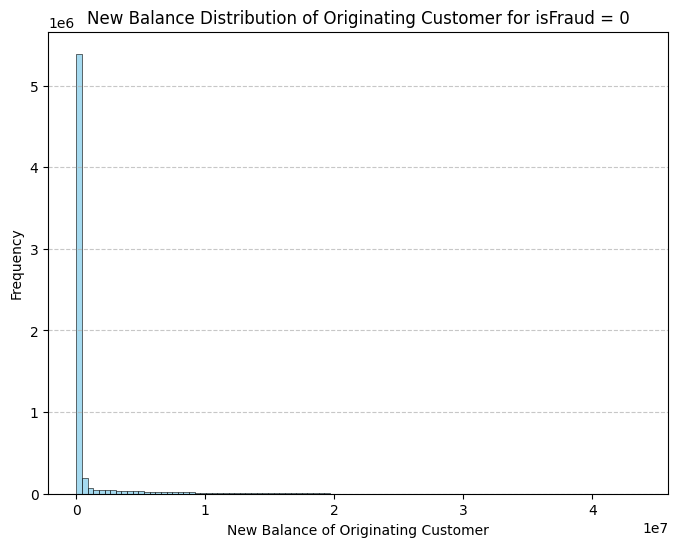

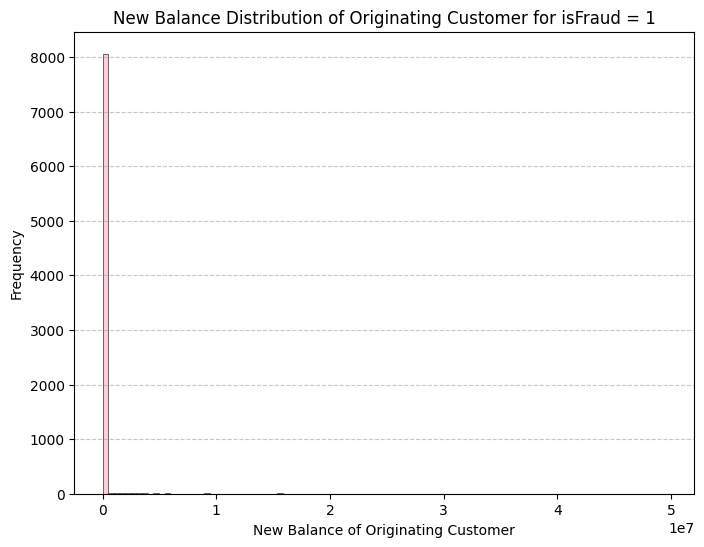

In [30]:
df_isFraud_0 = df[df['isFraud'] == 0]
plt.figure(figsize=(8, 6))
ax_newOrig_0 = sns.histplot(data=df_isFraud_0, x='newbalanceOrig', bins=100, color='skyblue')
plt.xlabel('New Balance of Originating Customer')
plt.ylabel('Frequency')
plt.title('New Balance Distribution of Originating Customer for isFraud = 0')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


df_isFraud_1 = df[df['isFraud'] == 1]
plt.figure(figsize=(8, 6))
ax_newOrig_1 = sns.histplot(data=df_isFraud_1, x='newbalanceOrig', bins=100, color='pink')
plt.xlabel('New Balance of Originating Customer')
plt.ylabel('Frequency')
plt.title('New Balance Distribution of Originating Customer for isFraud = 1')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Text(0.5, 1.0, 'New Balance of Originating Customer by Fraud Status')

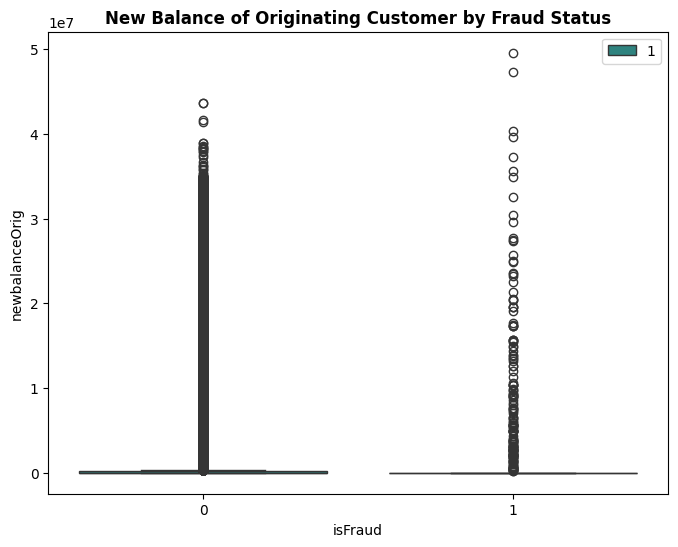

In [31]:
plt.figure(figsize=(8, 6))
sns.boxplot(x = 'isFraud', y = 'newbalanceOrig', data = df, palette="viridis", hue = 1)
plt.title('New Balance of Originating Customer by Fraud Status', fontweight="bold", size=12)

# Insights: The distribution of new balance of originating customer does not really distinguish between fraudulent and genuine transactions

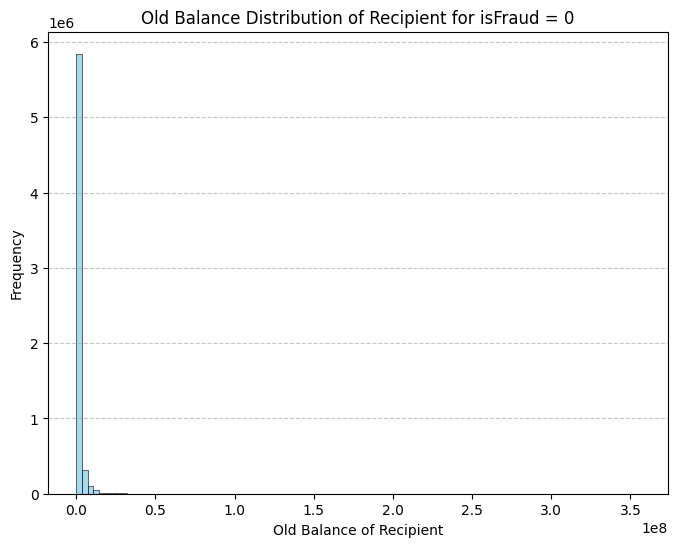

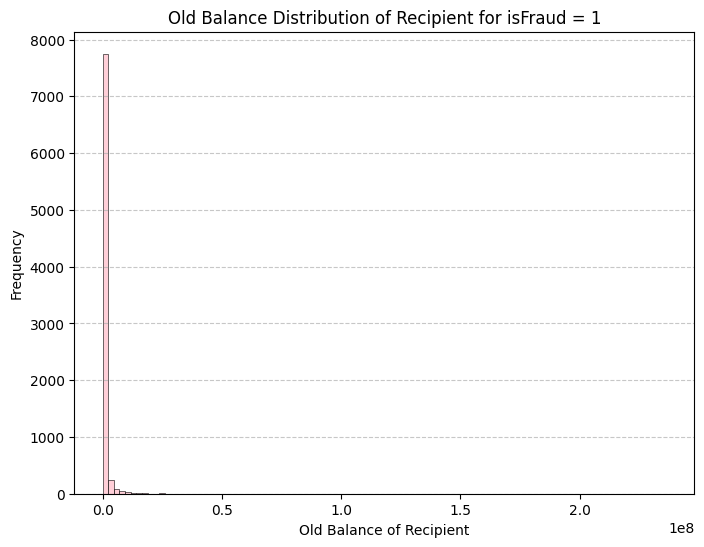

In [32]:
df_isFraud_0 = df[df['isFraud'] == 0]
plt.figure(figsize=(8, 6))
ax_oldDest_0 = sns.histplot(data=df_isFraud_0, x='oldbalanceDest', bins=100, color='skyblue')
plt.xlabel('Old Balance of Recipient')
plt.ylabel('Frequency')
plt.title('Old Balance Distribution of Recipient for isFraud = 0')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

df_isFraud_1 = df[df['isFraud'] == 1]
plt.figure(figsize=(8, 6))
ax_oldDest_1 = sns.histplot(data=df_isFraud_1, x='oldbalanceDest', bins=100, color='pink')
plt.xlabel('Old Balance of Recipient')
plt.ylabel('Frequency')
plt.title('Old Balance Distribution of Recipient for isFraud = 1')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Text(0.5, 1.0, 'Old Balance of Recipient by Fraud Status')

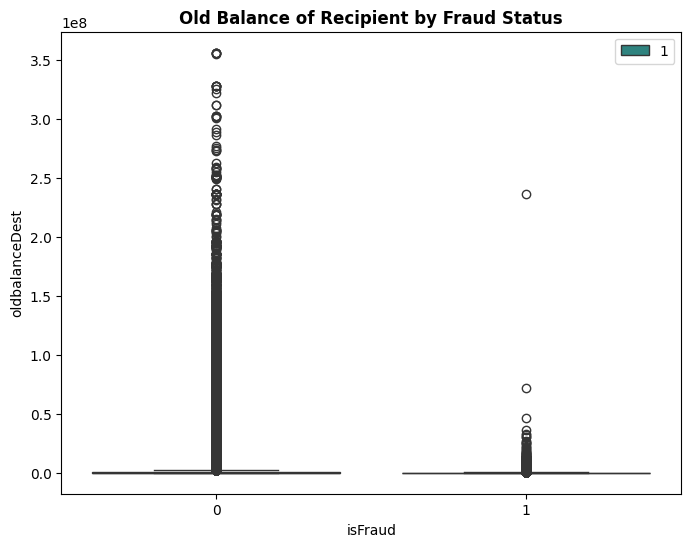

In [33]:
plt.figure(figsize=(8, 6))
sns.boxplot(x = 'isFraud', y = 'oldbalanceDest', data = df, palette="viridis", hue=1)
plt.title('Old Balance of Recipient by Fraud Status', fontweight="bold", size=12)

# Insights: The distribution of old balance of recipient customer does not really distinguish between fraudulent and genuine transactions

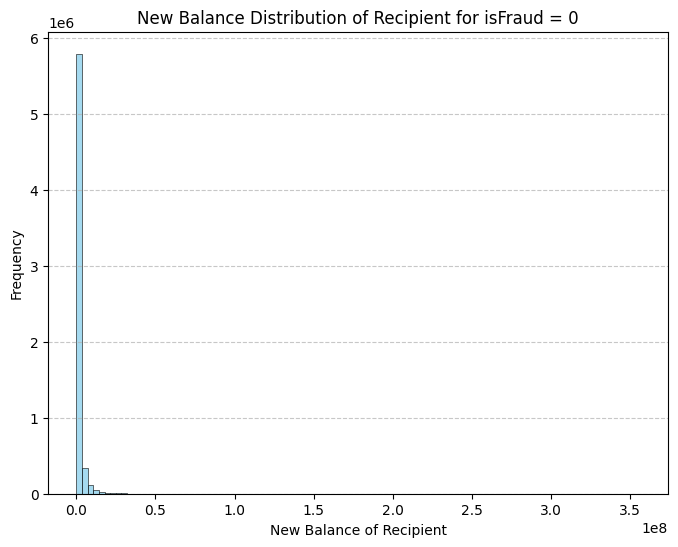

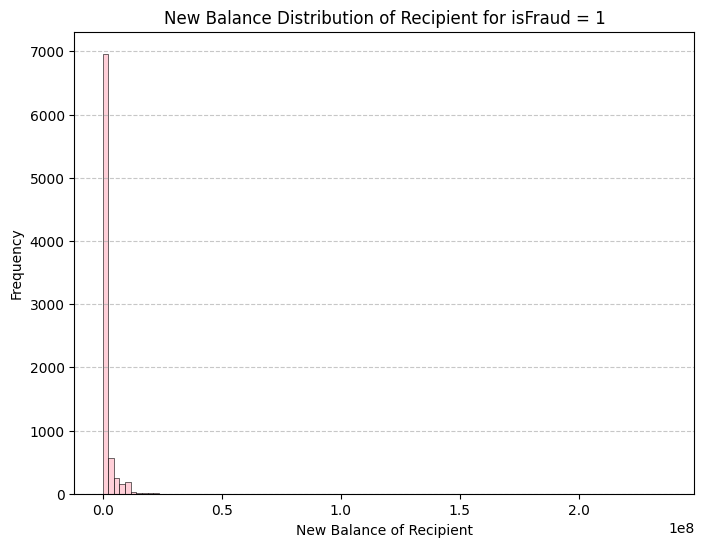

In [34]:
df_isFraud_0 = df[df['isFraud'] == 0]
plt.figure(figsize=(8, 6))
ax_newDest_0 = sns.histplot(data=df_isFraud_0, x='newbalanceDest', bins=100, color='skyblue')
plt.xlabel('New Balance of Recipient')
plt.ylabel('Frequency')
plt.title('New Balance Distribution of Recipient for isFraud = 0')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


df_isFraud_1 = df[df['isFraud'] == 1]
plt.figure(figsize=(8, 6))
ax_newDest_1 = sns.histplot(data=df_isFraud_1, x='newbalanceDest', bins=100, color='pink')
plt.xlabel('New Balance of Recipient')
plt.ylabel('Frequency')
plt.title('New Balance Distribution of Recipient for isFraud = 1')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Text(0.5, 1.0, 'New Balance of Recipient by Fraud Status')

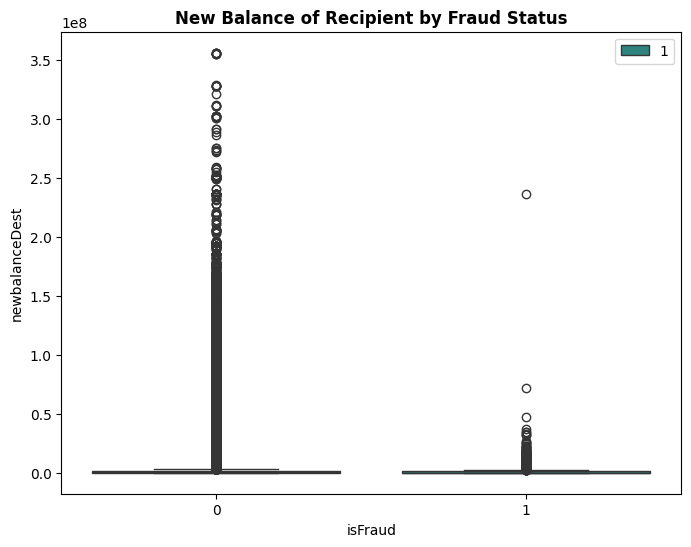

In [35]:
plt.figure(figsize=(8, 6))
sns.boxplot(x = 'isFraud', y = 'newbalanceDest', data = df, palette="viridis", hue = 1)
plt.title('New Balance of Recipient by Fraud Status', fontweight="bold", size=12)

# Insights: The distribution of new balance of recipient customer does not really distinguish between fraudulent and genuine transactions

In [36]:
error_orig_bal = sum(df["oldbalanceOrig"] - df["amount"] != df["newbalanceOrig"])
error_dest_bal = sum(df["oldbalanceDest"] + df["amount"] != df["newbalanceDest"])
print("Percentage of observations where errors in originator account balances are observed: ", 100*round(error_orig_bal/len(df),2))
print("Percentage of observations where errors in recipient account balances are observed: ", 100*round(error_dest_bal/len(df),2))

Percentage of observations where errors in originator account balances are observed:  85.0
Percentage of observations where errors in recipient account balances are observed:  74.0


In [37]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_encoded = df.copy()
for column in df_encoded.select_dtypes(include=[object]):
    df_encoded[column] = le.fit_transform(df_encoded[column])

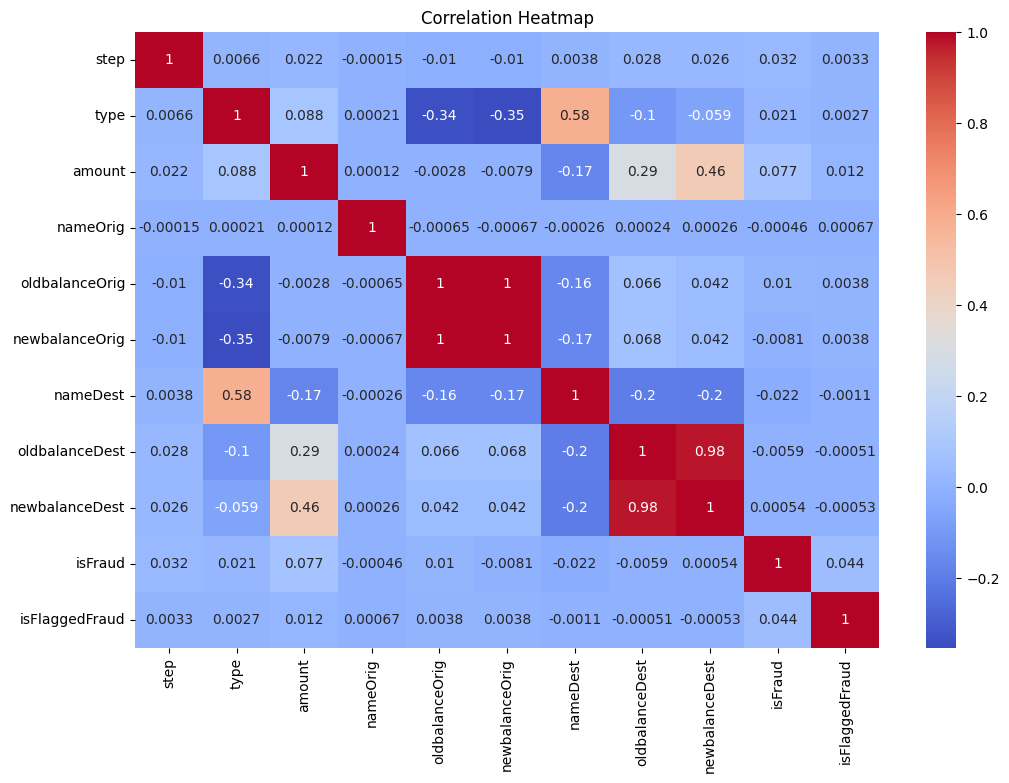

In [38]:
correlation_matrix = df_encoded.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

**STEP 4: DATA CLEANING**

In [9]:
columns_to_drop = ['nameOrig', 'nameDest', 'isFlaggedFraud']
df.drop(columns=columns_to_drop, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   oldbalanceOrig  float64
 4   newbalanceOrig  float64
 5   oldbalanceDest  float64
 6   newbalanceDest  float64
 7   isFraud         int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 388.3+ MB


In [10]:
df = df[~df['type'].isin(['CASH_IN', 'DEBIT', 'PAYMENT'])]

In [11]:
df.shape

(2770409, 8)

**STEP 5 - FEATURE ENGINEERING**

In [12]:
df.loc[:,'errorBalanceOrig'] = df['newbalanceOrig'] + df['amount'] - df['oldbalanceOrig']
df.loc[:,'errorBalanceDest'] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']

**STEP 6: ENCODING**

In [13]:
df_encoded = pd.get_dummies(df, columns=['type'])
df_encoded.head()

step     amount  oldbalanceOrig  newbalanceOrig  oldbalanceDest  newbalanceDest  isFraud  errorBalanceOrig  errorBalanceDest  type_CASH_OUT  type_TRANSFER
2      1     181.00           181.0             0.0             0.0            0.00        1              0.00             181.0          False           True
3      1     181.00           181.0             0.0         21182.0            0.00        1              0.00           21363.0           True          False
15     1  229133.94         15325.0             0.0          5083.0        51513.44        0         213808.94          182703.5           True          False
19     1  215310.30           705.0             0.0         22425.0            0.00        0         214605.30          237735.3          False           True
24     1  311685.89         10835.0             0.0          6267.0      2719172.89        0         300850.89        -2401220.0          False           True

**STEP 7: UNDERSAMPLING TO SOLVE CLASS IMBALANCE**

In [14]:
majority_class = df_encoded[df_encoded['isFraud'] == 0]
minority_class = df_encoded[df_encoded['isFraud'] == 1]
min_samples = len(minority_class)
majority_undersampled = resample(majority_class, n_samples=min_samples, replace=False, random_state=60)
df_balanced = pd.concat([majority_undersampled, minority_class])


[Text(0, 0, '8213'), Text(0, 0, '8213')]

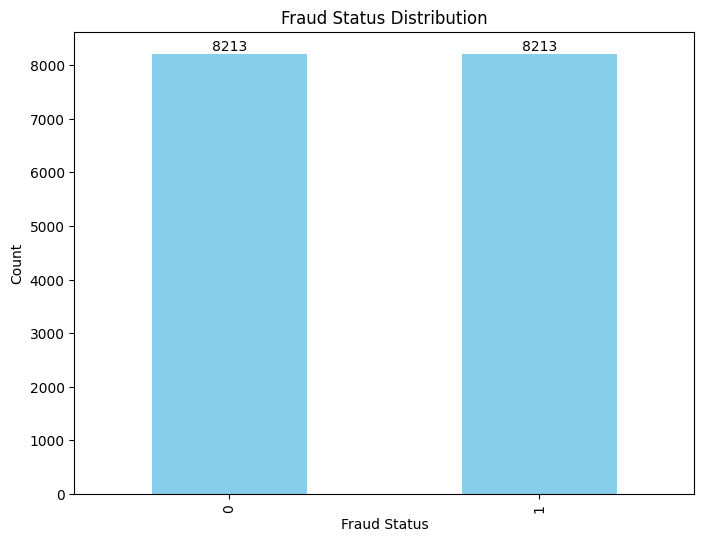

In [15]:
fraud_count_balanced = df_balanced['isFraud'].value_counts()
plt.figure(figsize=(8, 6))
ax_fraud_balanced = fraud_count_balanced.plot(kind='bar', color='skyblue')
plt.xlabel('Fraud Status')
plt.ylabel('Count')
plt.title('Fraud Status Distribution')
ax_fraud_balanced.bar_label(ax_fraud_balanced.containers[0], fontsize=10, color='black', labels=fraud_count_balanced.values)

In [16]:
fraud_count_balanced = df_balanced['isFraud'].value_counts()
print("Fraud Status Count in the Balanced Dataset:")
print (fraud_count_balanced)

fraud_percentage_balanced = df_balanced['isFraud'].value_counts(normalize=True) * 100
print("Fraud Status Percentage in the Balanced Dataset:")
print(fraud_percentage_balanced)

Fraud Status Count in the Balanced Dataset:
isFraud
0    8213
1    8213
Name: count, dtype: int64
Fraud Status Percentage in the Balanced Dataset:
isFraud
0    50.0
1    50.0
Name: proportion, dtype: float64


**STEP 8: TRAIN TEST SPLIT**

In [17]:
le = LabelEncoder()
df_balanced["type_CASH_OUT"] = le.fit_transform(df_balanced["type_CASH_OUT"])
df_balanced["type_TRANSFER"] = le.fit_transform(df_balanced["type_TRANSFER"])

In [18]:
# Train test split

x = df_balanced.drop('isFraud', axis=1)
y = df_balanced['isFraud']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=60, stratify=y) # 70:30 ratio of train to test

In [19]:
x_train.head()

step      amount  oldbalanceOrig  newbalanceOrig  oldbalanceDest  newbalanceDest  errorBalanceOrig  errorBalanceDest  type_CASH_OUT  type_TRANSFER
1069257   121  1241118.86      1241118.86             0.0     30436340.62     31677459.48              0.00              0.00              1              0
4845867   347   158389.96        36082.00             0.0            0.00       158389.96         122307.96              0.00              1              0
6053152   495    58737.53        58737.53             0.0            0.00            0.00              0.00          58737.53              0              1
410906     18  1102133.90      1102133.90             0.0       306228.56      1408362.45              0.00              0.01              1              0
6346140   694   186567.41       186567.41             0.0            0.00       186567.41              0.00              0.00              1              0

In [20]:
y_train.head()

1069257    1
4845867    0
6053152    1
410906     1
6346140    1
Name: isFraud, dtype: int64

In [21]:
fraud_count_train_split = y_train.value_counts()
print("Fraud Status Count in Train Data:")
print (fraud_count_train_split)

fraud_count_test_split = y_test.value_counts()
print("Fraud Status Count in Test Data:")
print (fraud_count_test_split)

Fraud Status Count in Train Data:
isFraud
1    5749
0    5749
Name: count, dtype: int64
Fraud Status Count in Test Data:
isFraud
0    2464
1    2464
Name: count, dtype: int64


**STEP 9: MODELING**

*MODEL A1: Random Forest (baseline)*

In [49]:
rf = RandomForestClassifier(random_state=42, n_estimators=20, max_depth=10, n_jobs=-1, verbose = 1)

rf.fit(x_train, y_train)

ytra_pred_rf = rf.predict(x_train)
y_pred_rf = rf.predict(x_test)

train_accuracy_rf = accuracy_score(y_train, ytra_pred_rf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
train_class_report_rf = classification_report(y_train, ytra_pred_rf, digits=4)
class_report_rf = classification_report(y_test, y_pred_rf, digits=4)

print(f'Train Accuracy: {train_accuracy_rf:.4f}')
print(f'Test Accuracy: {accuracy_rf:.4f}')
print('Classification Report of Train Set Predictions using Random Forest Model:')
print(train_class_report_rf)
print('Classification Report of Test Set Predictions using Random Forest Model:')
print(class_report_rf)


Train Accuracy: 0.9991
Test Accuracy: 0.9980
Classification Report of Train Set Predictions using Random Forest Model:
              precision    recall  f1-score   support

           0     0.9984    0.9998    0.9991      5749
           1     0.9998    0.9984    0.9991      5749

    accuracy                         0.9991     11498
   macro avg     0.9991    0.9991    0.9991     11498
weighted avg     0.9991    0.9991    0.9991     11498

Classification Report of Test Set Predictions using Random Forest Model:
              precision    recall  f1-score   support

           0     0.9964    0.9996    0.9980      2464
           1     0.9996    0.9963    0.9980      2464

    accuracy                         0.9980      4928
   macro avg     0.9980    0.9980    0.9980      4928
weighted avg     0.9980    0.9980    0.9980      4928



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  10 out of  20 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  20 out of  20 | elapsed:    0.0s finished


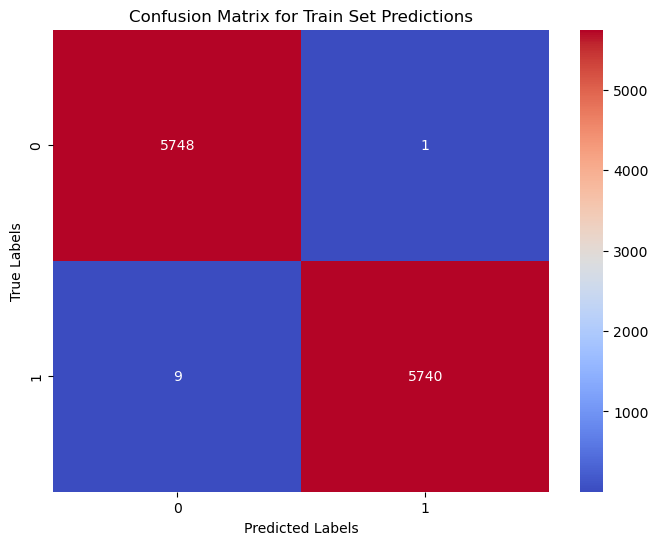

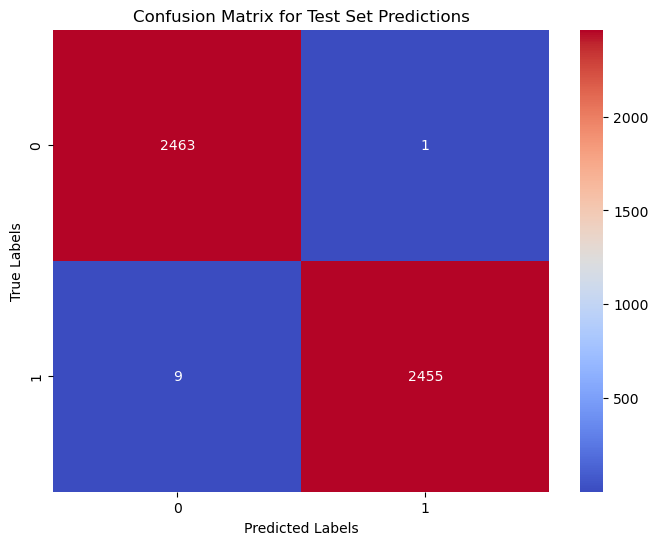

In [50]:
train_conf_matrix_rf = confusion_matrix(y_train, ytra_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(train_conf_matrix_rf, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Train Set Predictions')
plt.show()

conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Test Set Predictions')
plt.show()

In [51]:
fpr_test_rf, tpr_test_rf, _ = roc_curve(y_test, y_pred_rf)
roc_auc_test_rf = auc(fpr_test_rf, tpr_test_rf)

In [52]:
rf_params = rf.get_params()
print(rf_params)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 20, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 1, 'warm_start': False}


*MODEL A2: Tuned Random Forest*


In [53]:
param_grid_rf = {
    'n_estimators': [30, 50, 150, 200],
    'max_depth': [2, 10, 20, 30]
}

rf_tuned = RandomForestClassifier(random_state=42)

grid_search_rf = GridSearchCV(estimator=rf_tuned, param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=2)

grid_search_rf.fit(x_train, y_train)

best_rf = grid_search_rf.best_estimator_

ytra_pred_rf_tuned = best_rf.predict(x_train)
y_pred_rf_tuned = best_rf.predict(x_test)

train_accuracy_rf_tuned = accuracy_score(y_train, ytra_pred_rf_tuned)
accuracy_rf_tuned = accuracy_score(y_test, y_pred_rf_tuned)
train_class_report_rf_tuned = classification_report(y_train, ytra_pred_rf_tuned, digits=4)
class_report_rf_tuned = classification_report(y_test, y_pred_rf_tuned, digits=4)

print(f'Best Hyperparameters for Random Forest Model: {grid_search_rf.best_params_}')
print(f'Train Accuracy: {train_accuracy_rf_tuned:.4f}')
print(f'Test Accuracy: {accuracy_rf_tuned:.4f}')
print('Classification Report of Train Set Predictions using Tuned Random Forest Model:')
print(train_class_report_rf_tuned)
print('Classification Report of Test Set Predictions using Tuned Random Forest Model:')
print(class_report_rf_tuned)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Hyperparameters for Random Forest Model: {'max_depth': 10, 'n_estimators': 150}
Train Accuracy: 0.9995
Test Accuracy: 0.9982
Classification Report of Train Set Predictions using Tuned Random Forest Model:
              precision    recall  f1-score   support

           0     0.9990    1.0000    0.9995      5749
           1     1.0000    0.9990    0.9995      5749

    accuracy                         0.9995     11498
   macro avg     0.9995    0.9995    0.9995     11498
weighted avg     0.9995    0.9995    0.9995     11498

Classification Report of Test Set Predictions using Tuned Random Forest Model:
              precision    recall  f1-score   support

           0     0.9964    1.0000    0.9982      2464
           1     1.0000    0.9963    0.9982      2464

    accuracy                         0.9982      4928
   macro avg     0.9982    0.9982    0.9982      4928
weighted avg     0.9982    0.9982    0.9982      49

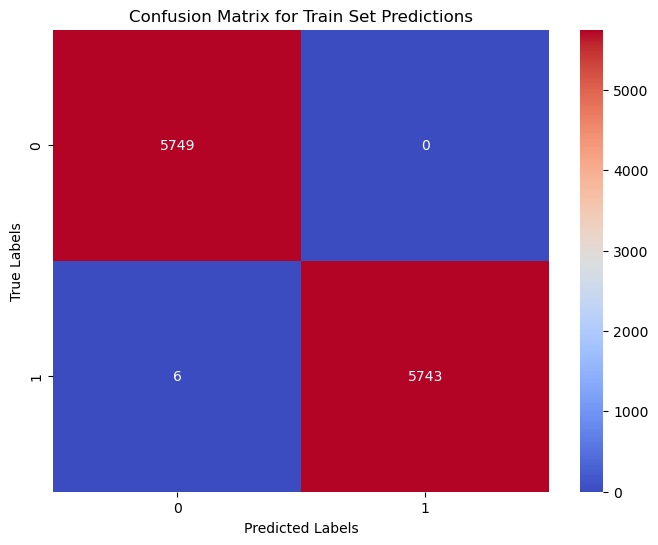

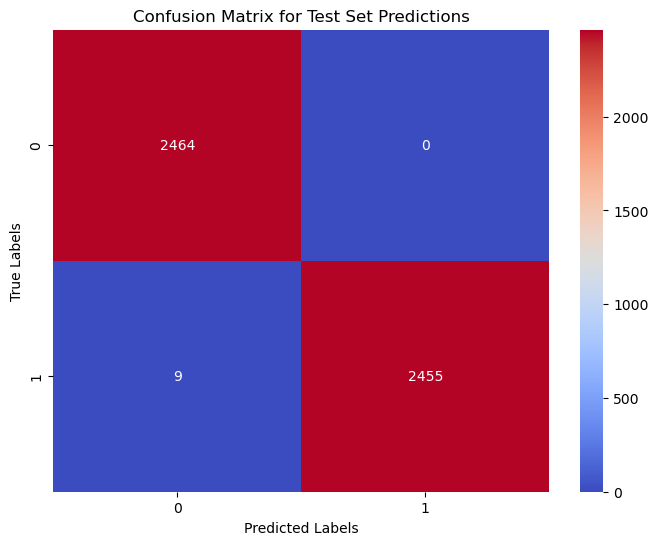

In [54]:
train_conf_matrix_rf_tuned = confusion_matrix(y_train, ytra_pred_rf_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(train_conf_matrix_rf_tuned, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Train Set Predictions')
plt.show()

conf_matrix_rf_tuned = confusion_matrix(y_test, y_pred_rf_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf_tuned, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Test Set Predictions')
plt.show()

In [55]:
# Saving the best tuned model to a file
joblib.dump(best_rf, 'best_models/best_rf_model.pkl')

['best_models/best_rf_model.pkl']

In [56]:
loaded_best_rf = joblib.load('best_models/best_rf_model.pkl')

In [57]:
y_pred_loaded_rf_tuned = loaded_best_rf.predict(x_test)

fpr_loaded_rf_tuned, tpr_loaded_rf_tuned, _ = roc_curve(y_test, y_pred_loaded_rf_tuned)

roc_auc_loaded_rf_tuned = auc(fpr_loaded_rf_tuned, tpr_loaded_rf_tuned)

In [58]:
rf_tuned_params = best_rf.get_params()
print(rf_tuned_params)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 150, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


*MODEL B1: XGBoost*

In [59]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic',
                              random_state=42,
                              n_estimators=100,
                              max_depth=5,
                              learning_rate=0.1,
                              min_child_weight=1,
                              gamma=0,
                              subsample=1.0,
                              colsample_bytree=1.0)

xgb_model.fit(x_train, y_train)

ytra_pred_xgb = xgb_model.predict(x_train)
y_pred_xgb = xgb_model.predict(x_test)

train_accuracy_xgb = accuracy_score(y_train, ytra_pred_xgb)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
train_class_report_xgb = classification_report(y_train, ytra_pred_xgb, digits=4)
class_report_xgb = classification_report(y_test, y_pred_xgb, digits=4)

print(f'Train Accuracy: {train_accuracy_xgb:.4f}')
print(f'Test Accuracy: {accuracy_xgb:.4f}')
print('Classification Report of Train Set Predictions using XGBoost Model:')
print(train_class_report_xgb)
print('Classification Report of Test Set Predictions using XGBoost Model:')
print(class_report_xgb)

Train Accuracy: 0.9990
Test Accuracy: 0.9976
Classification Report of Train Set Predictions using XGBoost Model:
              precision    recall  f1-score   support

           0     0.9983    0.9997    0.9990      5749
           1     0.9997    0.9983    0.9990      5749

    accuracy                         0.9990     11498
   macro avg     0.9990    0.9990    0.9990     11498
weighted avg     0.9990    0.9990    0.9990     11498

Classification Report of Test Set Predictions using XGBoost Model:
              precision    recall  f1-score   support

           0     0.9968    0.9984    0.9976      2464
           1     0.9984    0.9968    0.9976      2464

    accuracy                         0.9976      4928
   macro avg     0.9976    0.9976    0.9976      4928
weighted avg     0.9976    0.9976    0.9976      4928



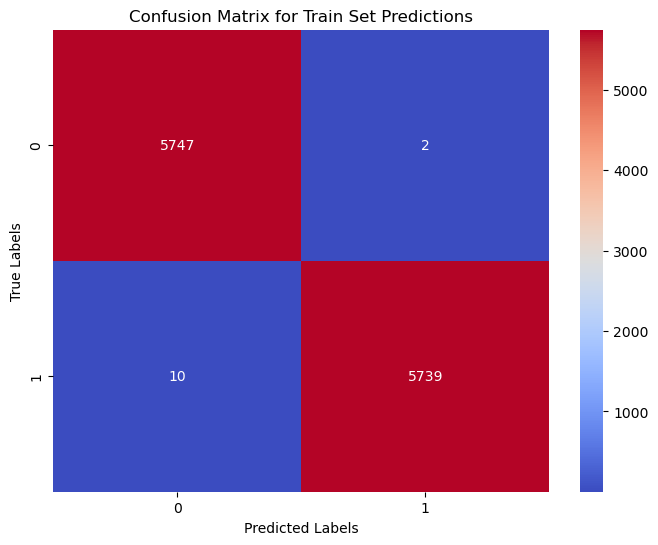

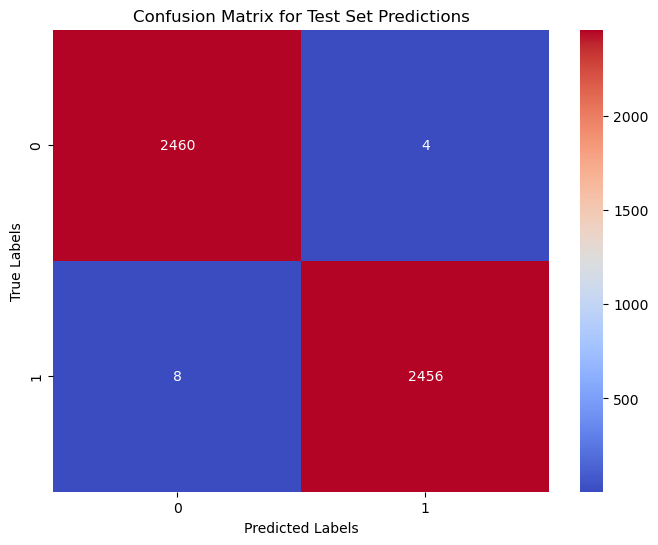

In [60]:
train_conf_matrix_xgb = confusion_matrix(y_train, ytra_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(train_conf_matrix_xgb, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Train Set Predictions')
plt.show()

conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Test Set Predictions')
plt.show()

In [61]:
fpr_test_xgb, tpr_test_xgb, _ = roc_curve(y_test, y_pred_xgb)
roc_auc_test_xgb = auc(fpr_test_xgb, tpr_test_xgb)


In [62]:
xgb_model_params = xgb_model.get_params()
print(xgb_model_params)

{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 1.0, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 1.0, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


*MODEL B2: Tuned XGBoost*

In [63]:
param_grid_xgb = {
   'n_estimators': [50, 100, 150, 200],
   'max_depth': [5, 10, 20],
   'min_child_weight': [3, 5, 7],
   'learning_rate': [0.1, 0.2, 0.3],
   'gamma': [0, 3, 5],
   'subsample': [1.0],
   'colsample_bytree': [1.0]
}

xgb_tuned = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

grid_search_xgb = GridSearchCV(estimator=xgb_tuned, param_grid=param_grid_xgb, cv=5, n_jobs=-1, verbose=2)

grid_search_xgb.fit(x_train, y_train)

best_xgb = grid_search_xgb.best_estimator_

ytra_pred_xgb_tuned = best_xgb.predict(x_train)
y_pred_xgb_tuned = best_xgb.predict(x_test)

train_accuracy_xgb_tuned = accuracy_score(y_train, ytra_pred_xgb_tuned)
accuracy_xgb_tuned = accuracy_score(y_test, y_pred_xgb_tuned)
train_class_report_xgb_tuned = classification_report(y_train, ytra_pred_xgb_tuned, digits=4)
class_report_xgb_tuned = classification_report(y_test, y_pred_xgb_tuned, digits=4)

print(f'Best Hyperparameters for XGBoost Model: {grid_search_xgb.best_params_}')
print(f'Train Accuracy: {train_accuracy_xgb_tuned:.4f}')
print(f'Test Accuracy: {accuracy_xgb_tuned:.4f}')
print('Classification Report of Train Set Predictions using Tuned XGBoost Model:')
print(train_class_report_xgb_tuned)
print('Classification Report of Test Set Predictions using Tuned XGBoost Model:')
print(class_report_xgb_tuned)


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Hyperparameters for XGBoost Model: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 1.0}
Train Accuracy: 0.9980
Test Accuracy: 0.9976
Classification Report of Train Set Predictions using Tuned XGBoost Model:
              precision    recall  f1-score   support

           0     0.9964    0.9997    0.9980      5749
           1     0.9997    0.9963    0.9980      5749

    accuracy                         0.9980     11498
   macro avg     0.9980    0.9980    0.9980     11498
weighted avg     0.9980    0.9980    0.9980     11498

Classification Report of Test Set Predictions using Tuned XGBoost Model:
              precision    recall  f1-score   support

           0     0.9964    0.9988    0.9976      2464
           1     0.9988    0.9963    0.9976      2464

    accuracy                         0.9976      4928
   macro avg     0.99

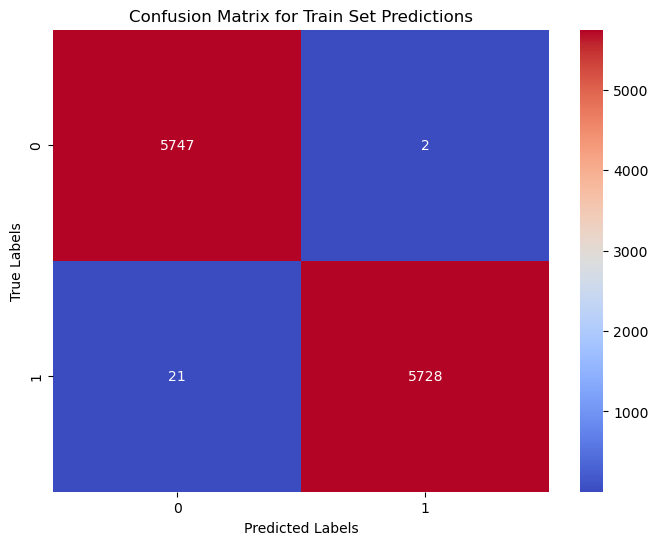

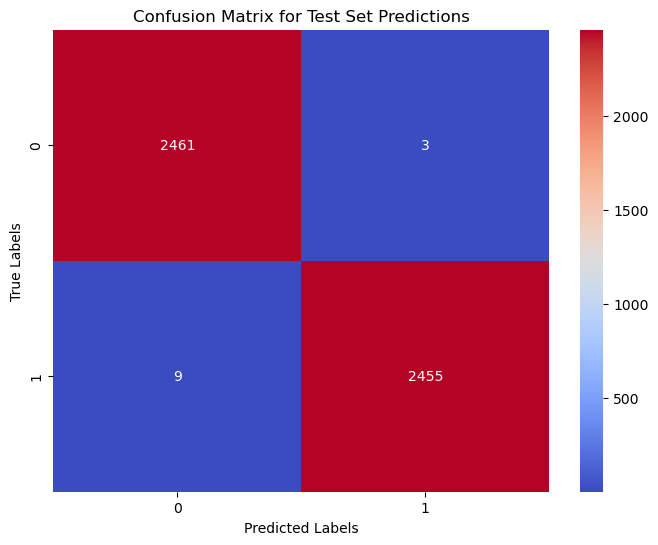

In [64]:
train_conf_matrix_xgb_tuned = confusion_matrix(y_train, ytra_pred_xgb_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(train_conf_matrix_xgb_tuned, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Train Set Predictions')
plt.show()

conf_matrix_xgb_tuned = confusion_matrix(y_test, y_pred_xgb_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb_tuned, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Test Set Predictions')
plt.show()

In [65]:
# Saving the best tuned model to a file
joblib.dump(best_xgb, 'best_models/best_xgb_model.pkl')

['best_models/best_xgb_model.pkl']

In [66]:
loaded_best_xgb = joblib.load('best_models/best_xgb_model.pkl')

In [67]:
y_pred_loaded_xgb_tuned = loaded_best_xgb.predict(x_test)

fpr_loaded_xgb_tuned, tpr_loaded_xgb_tuned, _ = roc_curve(y_test, y_pred_loaded_xgb_tuned)

roc_auc_loaded_xgb_tuned = auc(fpr_loaded_xgb_tuned, tpr_loaded_xgb_tuned)

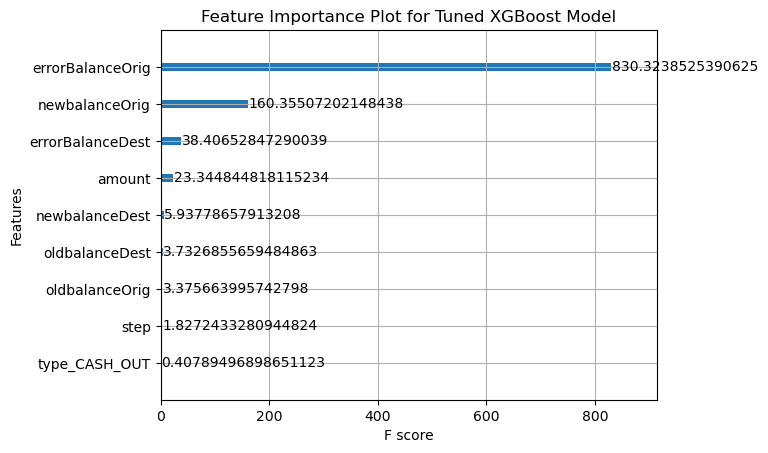

In [68]:
xgb.plot_importance(loaded_best_xgb, importance_type='gain')
plt.title('Feature Importance Plot for Tuned XGBoost Model')
plt.show()

In [69]:
xgb_tuned_params = best_xgb.get_params()
print(xgb_tuned_params)

{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 1.0, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': 7, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 1.0, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


*MODEL C1: MULTILAYER PERCEPTRON*

In [73]:
mlp = MLPClassifier(hidden_layer_sizes=(50, 25), random_state=42)

mlp.fit(x_train, y_train)

ytra_pred_mlp = mlp.predict(x_train)
y_pred_mlp = mlp.predict(x_test)

train_accuracy_mlp = accuracy_score(y_train, ytra_pred_mlp)
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
train_class_report_mlp = classification_report(y_train, ytra_pred_mlp, digits=4)
class_report_mlp = classification_report(y_test, y_pred_mlp, digits=4)

print(f'Train Accuracy: {train_accuracy_mlp:.4f}')
print(f'Accuracy: {accuracy_mlp:.4f}')
print('Classification Report of Train Set Predictions using MLP model:')
print(train_class_report_mlp)
print('Classification Report of Test Set Predictions using MLP model:')
print(class_report_mlp)

Train Accuracy: 0.9526
Accuracy: 0.9564
Classification Report of Train Set Predictions using MLP model:
              precision    recall  f1-score   support

           0     0.9174    0.9948    0.9545      5749
           1     0.9943    0.9104    0.9505      5749

    accuracy                         0.9526     11498
   macro avg     0.9558    0.9526    0.9525     11498
weighted avg     0.9558    0.9526    0.9525     11498

Classification Report of Test Set Predictions using MLP model:
              precision    recall  f1-score   support

           0     0.9229    0.9959    0.9580      2464
           1     0.9956    0.9168    0.9546      2464

    accuracy                         0.9564      4928
   macro avg     0.9592    0.9564    0.9563      4928
weighted avg     0.9592    0.9564    0.9563      4928



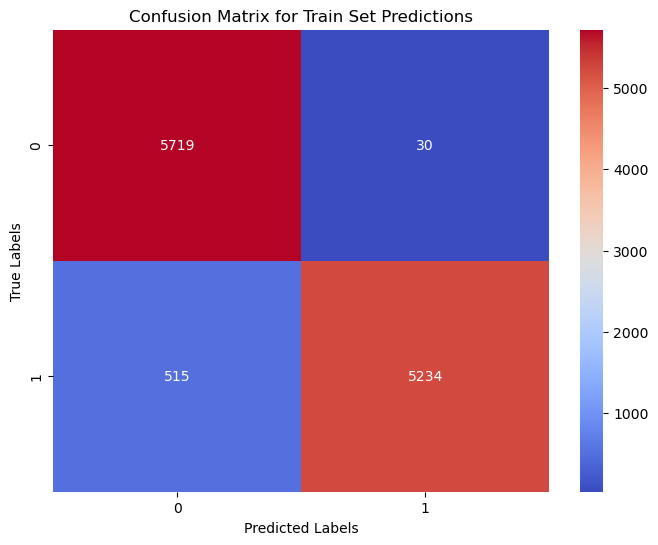

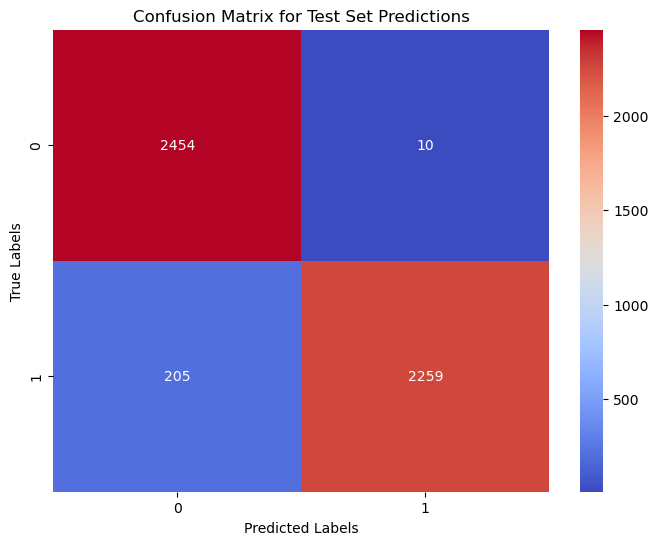

In [74]:
train_conf_matrix_mlp = confusion_matrix(y_train, ytra_pred_mlp)
plt.figure(figsize=(8, 6))
sns.heatmap(train_conf_matrix_mlp, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Train Set Predictions')
plt.show()

conf_matrix_mlp = confusion_matrix(y_test, y_pred_mlp)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_mlp, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Test Set Predictions')
plt.show()

In [75]:
fpr_test_mlp, tpr_test_mlp, _ = roc_curve(y_test, y_pred_mlp)
roc_auc_test_mlp = auc(fpr_test_mlp, tpr_test_mlp)

In [76]:
mlp_params = mlp.get_params()
print(mlp_params)

{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (50, 25), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 42, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


*Model C2: Tuned MLP*

In [77]:
param_grid_mlp = {
    'hidden_layer_sizes': [(50, 25), (100, 50), (200, 100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'max_iter': [200, 500, 1000]
}

mlp_tuned = MLPClassifier(random_state=42)

grid_search_mlp = GridSearchCV(estimator=mlp_tuned, param_grid=param_grid_mlp, cv=5, n_jobs=-1, verbose=2)

grid_search_mlp.fit(x_train, y_train)

best_mlp = grid_search_mlp.best_estimator_

ytra_pred_mlp_tuned = best_mlp.predict(x_train)
y_pred_mlp_tuned = best_mlp.predict(x_test)

train_accuracy_mlp_tuned = accuracy_score(y_train, ytra_pred_mlp_tuned)
accuracy_mlp_tuned = accuracy_score(y_test, y_pred_mlp_tuned)
train_class_report_mlp_tuned = classification_report(y_train, ytra_pred_mlp_tuned, digits=4)
class_report_mlp_tuned = classification_report(y_test, y_pred_mlp_tuned, digits=4)

print(f'Best Hyperparameters for MLP classifier: {grid_search_mlp.best_params_}')
print(f'Train Accuracy: {train_accuracy_mlp_tuned:.4f}')
print(f'Test Accuracy: {accuracy_mlp_tuned:.4f}')
print('Classification Report of Train Set Predictions using MLP classifier:')
print(train_class_report_mlp_tuned)
print('Classification Report of Test Set Predictions using MLP classifier:')
print(class_report_mlp_tuned)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Hyperparameters for MLP classifier: {'activation': 'relu', 'hidden_layer_sizes': (200, 100, 50), 'max_iter': 200, 'solver': 'adam'}
Train Accuracy: 0.9837
Test Accuracy: 0.9840
Classification Report of Train Set Predictions using MLP classifier:
              precision    recall  f1-score   support

           0     0.9780    0.9897    0.9838      5749
           1     0.9896    0.9777    0.9836      5749

    accuracy                         0.9837     11498
   macro avg     0.9838    0.9837    0.9837     11498
weighted avg     0.9838    0.9837    0.9837     11498

Classification Report of Test Set Predictions using MLP classifier:
              precision    recall  f1-score   support

           0     0.9826    0.9854    0.9840      2464
           1     0.9853    0.9825    0.9839      2464

    accuracy                         0.9840      4928
   macro avg     0.9840    0.9840    0.9840      4928
weighted avg     0.98

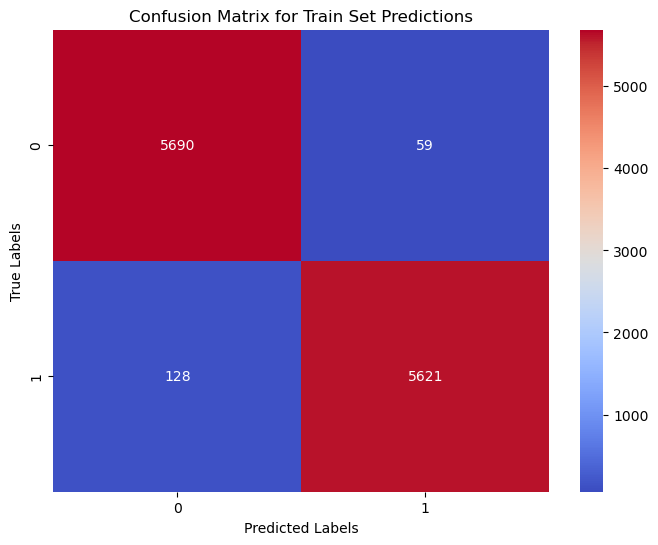

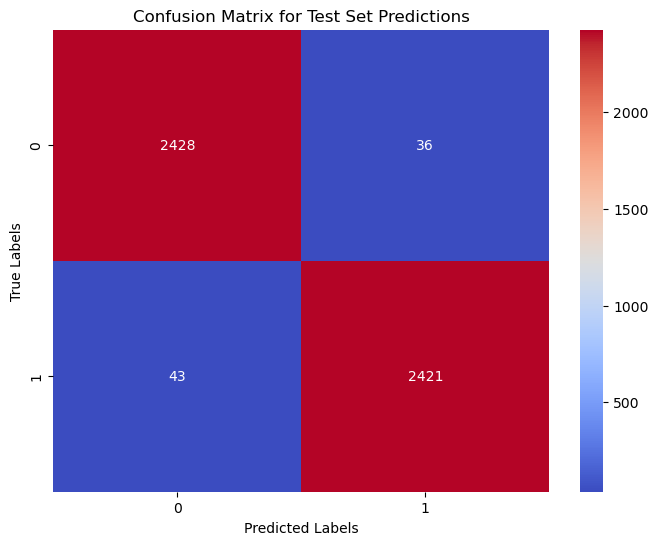

In [78]:
train_conf_matrix_mlp_tuned = confusion_matrix(y_train, ytra_pred_mlp_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(train_conf_matrix_mlp_tuned, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Train Set Predictions')
plt.show()

conf_matrix_mlp_tuned = confusion_matrix(y_test, y_pred_mlp_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_mlp_tuned, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Test Set Predictions')
plt.show()

In [79]:
# Saving the best tuned model to a file
joblib.dump(best_mlp, 'best_models/best_mlp_model.pkl')

['best_models/best_mlp_model.pkl']

In [80]:
loaded_best_mlp = joblib.load('best_models/best_mlp_model.pkl')

In [81]:
y_pred_loaded_mlp_tuned = loaded_best_mlp.predict(x_test)

fpr_loaded_mlp_tuned, tpr_loaded_mlp_tuned, _ = roc_curve(y_test, y_pred_loaded_mlp_tuned)

roc_auc_loaded_mlp_tuned = auc(fpr_loaded_mlp_tuned, tpr_loaded_mlp_tuned)

In [82]:
mlp_tuned_params = best_mlp.get_params()
print(mlp_tuned_params)

{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (200, 100, 50), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 42, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


*MULTIPLE ROC CURVE FOR MODEL COMPARISON*

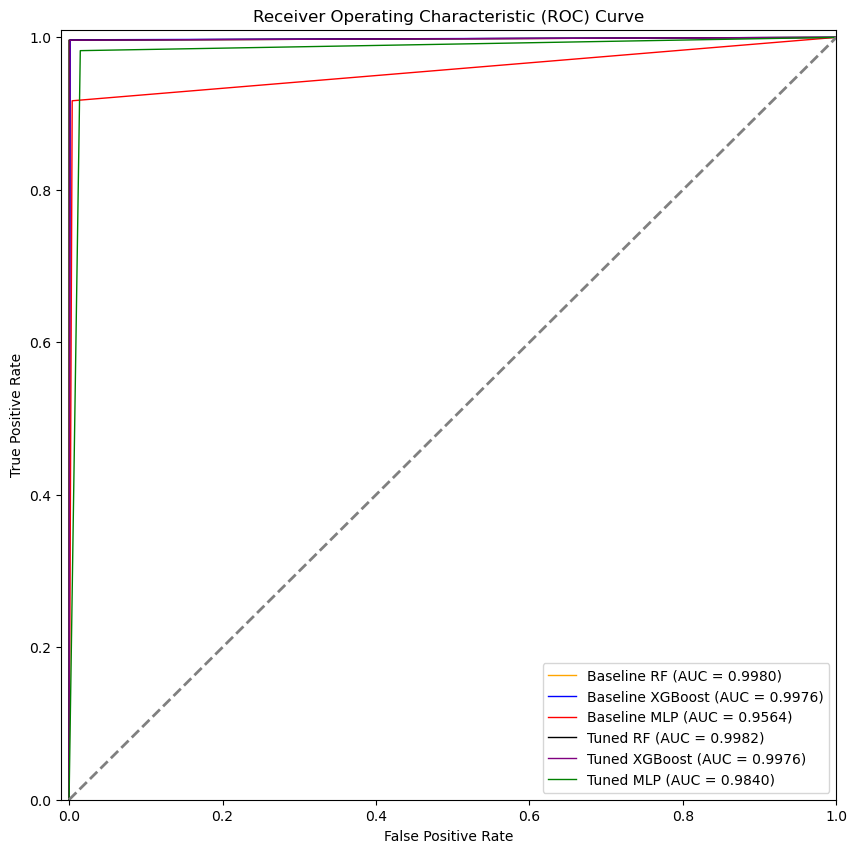

In [108]:
plt.figure(figsize=(10, 10))
plt.plot(fpr_test_rf, tpr_test_rf, color='orange', lw=1, label=f'Baseline RF (AUC = {roc_auc_test_rf:.4f})')
plt.plot(fpr_test_xgb, tpr_test_xgb, color='blue', lw=1, label=f'Baseline XGBoost (AUC = {roc_auc_test_xgb:.4f})')
plt.plot(fpr_test_mlp, tpr_test_mlp, color='red', lw=1, label=f'Baseline MLP (AUC = {roc_auc_test_mlp:.4f})')
plt.plot(fpr_loaded_rf_tuned, tpr_loaded_rf_tuned, color='black', lw=1, label=f'Tuned RF (AUC = {roc_auc_loaded_rf_tuned:.4f})')
plt.plot(fpr_loaded_xgb_tuned, tpr_loaded_xgb_tuned, color='purple', lw=1, label=f'Tuned XGBoost (AUC = {roc_auc_loaded_xgb_tuned:.4f})')
plt.plot(fpr_loaded_mlp_tuned, tpr_loaded_mlp_tuned, color='green', lw=1, label=f'Tuned MLP (AUC = {roc_auc_loaded_mlp_tuned:.4f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

**STAGE 4: APPLICATION OF SHAP AND LIME**

*4a. SHAP - Global explanation*

In [22]:
loaded_best_xgb = joblib.load('best_models/best_xgb_model.pkl')

In [23]:
shap_explainer = shap.TreeExplainer(loaded_best_xgb)

In [26]:
%%time

shap_value = shap_explainer.shap_values(x_test)

CPU times: total: 1.53 s
Wall time: 156 ms


In [64]:
shap_value

array([[-0.8494868 , -0.50857955,  0.46308297, ..., -0.0407296 ,
        -0.01402213,  0.        ],
       [ 0.79077095, -0.5451995 ,  0.3474603 , ..., -0.02519831,
        -0.01944633,  0.        ],
       [-0.89026433, -0.3434776 ,  0.14390357, ..., -0.04150406,
        -0.0088308 ,  0.        ],
       ...,
       [-0.34860045,  0.6012801 ,  0.202166  , ..., -0.02489997,
        -0.00800817,  0.        ],
       [-0.46259716,  0.14977682,  0.14863147, ..., -0.04150406,
         0.02663983,  0.        ],
       [-0.79370296, -0.34387112, -0.4753815 , ..., -0.0417214 ,
        -0.0088308 ,  0.        ]], dtype=float32)

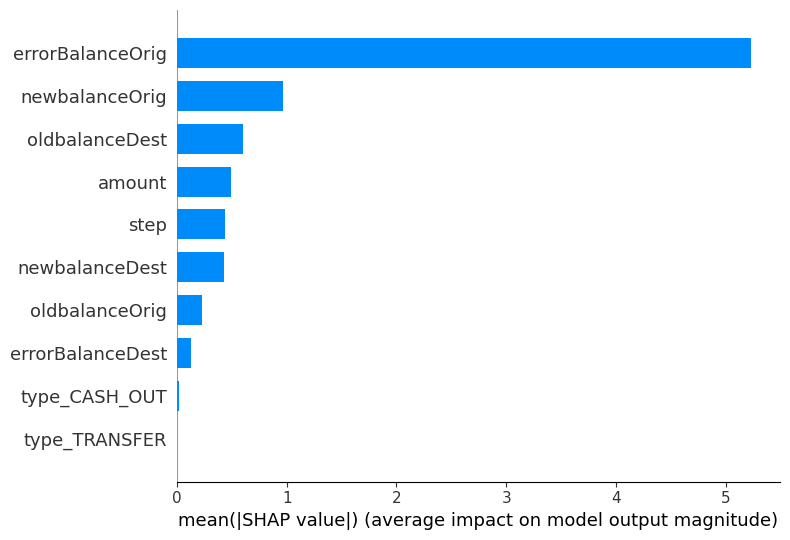

In [65]:
shap.summary_plot(shap_value, x_test, plot_type="bar")

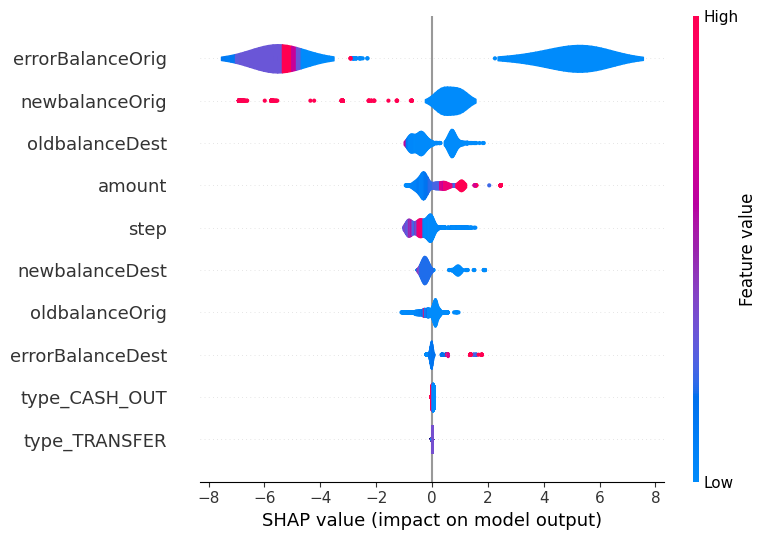

In [27]:
# Generating SHAP summary plot
shap.summary_plot(shap_value, x_test, plot_type="violin")

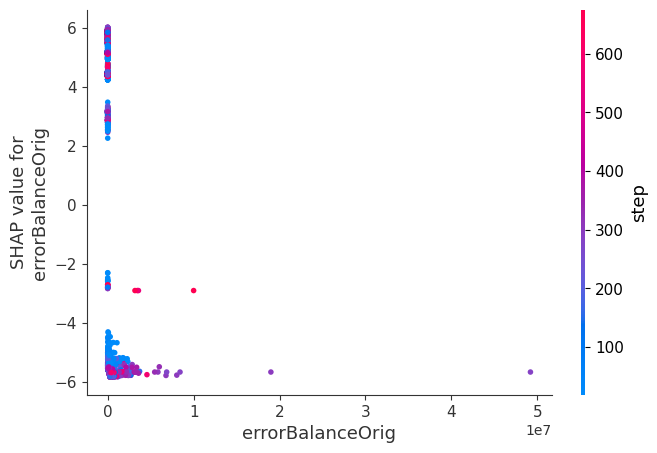

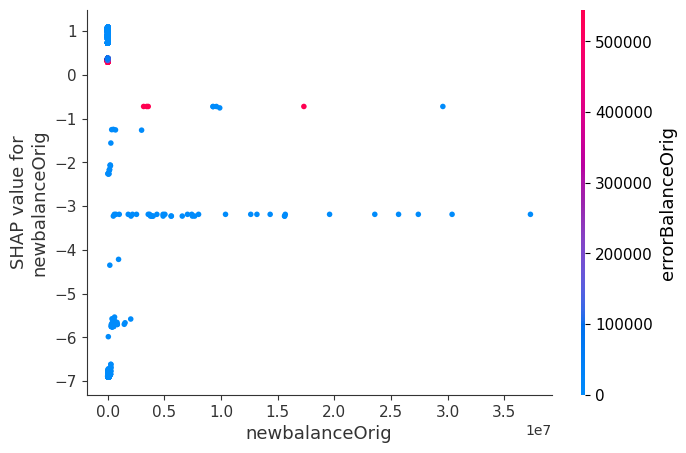

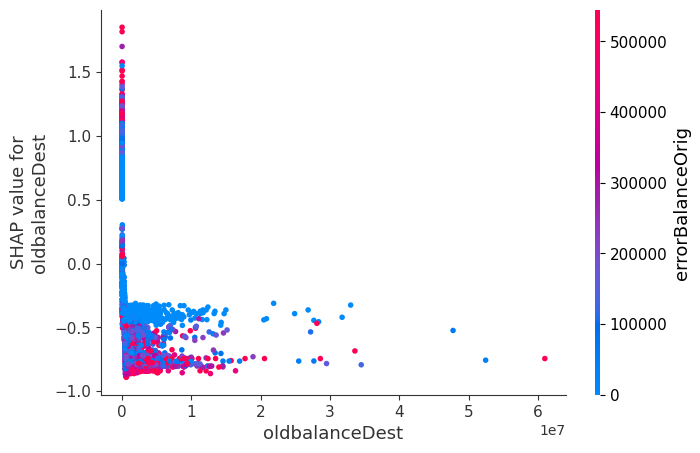

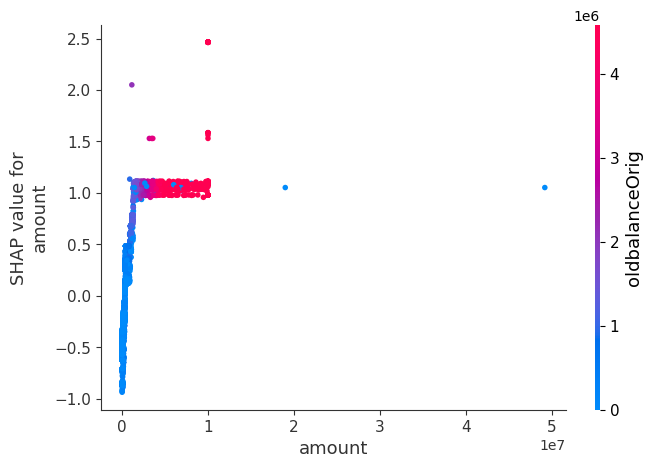

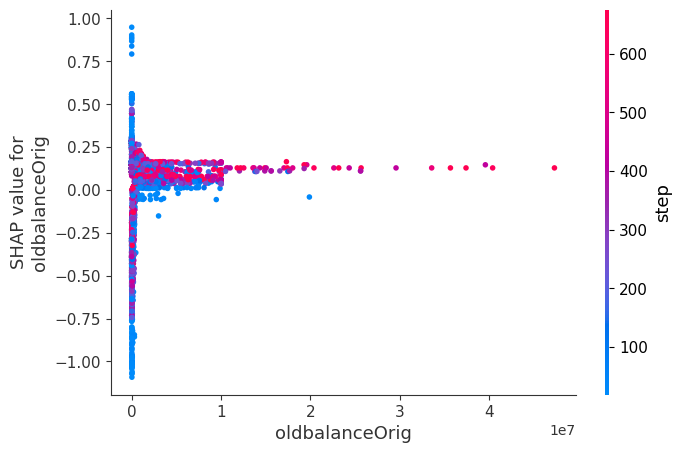

In [28]:
shap.dependence_plot("errorBalanceOrig", shap_value, x_test, interaction_index="auto")
shap.dependence_plot("newbalanceOrig", shap_value, x_test, interaction_index="auto")
shap.dependence_plot("oldbalanceDest", shap_value, x_test, interaction_index="auto")
shap.dependence_plot("amount", shap_value, x_test, interaction_index="auto")
shap.dependence_plot("oldbalanceOrig", shap_value, x_test, interaction_index="auto")

*4b. SHAP - Local Explanation*

In [23]:
mask_genuine = (y_test == 0)

indices_y_0 = x_test.index[mask_genuine][:5]

print("First 5 indices where transaction is genuine:", indices_y_0)

First 5 indices where transaction is genuine: Index([3028971, 114803, 5295177, 6026282, 3713758], dtype='int64')


In [30]:
df_balanced.loc[[114803]]

step   amount  oldbalanceOrig  newbalanceOrig  oldbalanceDest  newbalanceDest  isFraud  errorBalanceOrig  errorBalanceDest  type_CASH_OUT  type_TRANSFER
114803    11  9388.22             0.0             0.0       303170.69             0.0        0           9388.22         312558.91              1              0

In [31]:
x_test.loc[[114803]]

step   amount  oldbalanceOrig  newbalanceOrig  oldbalanceDest  newbalanceDest  errorBalanceOrig  errorBalanceDest  type_CASH_OUT  type_TRANSFER
114803    11  9388.22             0.0             0.0       303170.69             0.0           9388.22         312558.91              1              0

In [32]:
y_test.loc[[114803]]

114803    0
Name: isFraud, dtype: int64

In [33]:
instance_leg = x_test.loc[[114803]]
shap_value_1 = shap_explainer.shap_values(instance_leg)
shap.initjs()
shap.force_plot(shap_explainer.expected_value, shap_value_1[0], instance_leg)

In [34]:
mask_fraud = (y_test == 1)

indices_y_1 = x_test.index[mask_fraud][:5]

print("First 5 indices where transaction is fraudulent:", indices_y_1)

First 5 indices where transaction is fraudulent: Index([6100653, 1030347, 5597311, 6293771, 1070173], dtype='int64')


In [35]:
df_balanced.loc[[6338605]]

step      amount  oldbalanceOrig  newbalanceOrig  oldbalanceDest  newbalanceDest  isFraud  errorBalanceOrig  errorBalanceDest  type_CASH_OUT  type_TRANSFER
6338605   691  1518718.03      1518718.03             0.0             0.0      1518718.03        1               0.0               0.0              1              0

In [36]:
x_test.loc[[6338605]]

step      amount  oldbalanceOrig  newbalanceOrig  oldbalanceDest  newbalanceDest  errorBalanceOrig  errorBalanceDest  type_CASH_OUT  type_TRANSFER
6338605   691  1518718.03      1518718.03             0.0             0.0      1518718.03               0.0               0.0              1              0

In [37]:
y_test.loc[[6338605]]

6338605    1
Name: isFraud, dtype: int64

In [38]:
instance_fraud = x_test.loc[[6338605]]
shap_value_2 = shap_explainer.shap_values(instance_fraud)
shap.initjs()
shap.force_plot(shap_explainer.expected_value, shap_value_2[0], instance_fraud)

In [39]:
instance_fraud_2 = x_test.loc[[6338605]]
shap_value_2a = shap_explainer.shap_values(instance_fraud_2)
shap.initjs()
shap.force_plot(shap_explainer.expected_value, shap_value_2a[0], instance_fraud_2)

*4c. LIME*

In [84]:
%%time

import lime
lime_explainer = lime.lime_tabular.LimeTabularExplainer(x_test.values, mode="classification", feature_names=x_test.columns, class_names=['Legitimate','Fraud'])

CPU times: total: 0 ns
Wall time: 16.7 ms


In [24]:
predict_function = lambda x: loaded_best_xgb.predict_proba(x).astype(float)

In [86]:
class_name_mapping = {0: 'Legitimate', 1: 'Fraud'}

predicted_class = loaded_best_xgb.predict(x_test.loc[[114803]])
actual_class = y_test[114803]

print("Predicted class: ", class_name_mapping[predicted_class[0]])
print("Actual class:    ", class_name_mapping[actual_class])

chosen_instance_1 = x_test.loc[[114803]].values[0]
exp1 = lime_explainer.explain_instance(chosen_instance_1, predict_function)
exp1.show_in_notebook()

Predicted class:  Legitimate
Actual class:     Legitimate


In [105]:
predicted_class_2 = loaded_best_xgb.predict(x_test.loc[[6338605]])
actual_class_2 = y_test[6338605]

print("Predicted class: ", class_name_mapping[predicted_class_2[0]])
print("Actual class:    ", class_name_mapping[actual_class_2])

chosen_instance_2 = x_test.loc[[6338605]].values[0]
exp2 = lime_explainer.explain_instance(chosen_instance_2, predict_function)
exp2.show_in_notebook()

Predicted class:  Fraud
Actual class:     Fraud


In [106]:
print("Predicted class: ", class_name_mapping[predicted_class_2[0]])
print("Actual class:    ", class_name_mapping[actual_class_2])

exp2a = lime_explainer.explain_instance(chosen_instance_2, predict_function)
exp2a.show_in_notebook()

Predicted class:  Fraud
Actual class:     Fraud


4d. Alibi Model 

In [93]:
def explain_anchor(model, X_train, X_test, feature_names, num_samples=100):
    explainer = AnchorTabular(
        predictor = predict_function,
        feature_names=feature_names,
    )
    explainer.fit(X_train.values, disc_perc=(25, 50, 75))
    
    explanations = []
    instances = []
    for i in range(num_samples):
        instances.append(X_test.iloc[i])
        anchor = explainer.explain(X_test.iloc[i].values, threshold=0.95)
        explanations.append(anchor)
    return explanations, instances

In [97]:
anchor_explanations, instances = explain_anchor(loaded_best_xgb, x_train, x_test, x_train.columns.tolist(), num_samples=3)
anchor_explanations

[Explanation(meta={
   'name': 'AnchorTabular',
   'type': ['blackbox'],
   'explanations': ['local'],
   'params': {
               'seed': None,
               'disc_perc': (25, 50, 75),
               'threshold': 0.95,
               'delta': 0.1,
               'tau': 0.15,
               'batch_size': 100,
               'coverage_samples': 10000,
               'beam_size': 1,
               'stop_on_first': False,
               'max_anchor_size': None,
               'min_samples_start': 100,
               'n_covered_ex': 10,
               'binary_cache_size': 10000,
               'cache_margin': 1000,
               'verbose': False,
               'verbose_every': 1,
               'kwargs': {}}
             ,
   'version': '0.9.6'}
 , data={
   'anchor': ['errorBalanceOrig > 0.00', 'type_CASH_OUT > 0.00'],
   'precision': 1.0,
   'coverage': 0.3544,
   'raw': {
            'feature': [6, 8],
            'mean': [0.8678899082568807, 1.0],
            'precision': [0.86788

Anchor: ['errorBalanceOrig > 0.00', 'type_CASH_OUT > 0.00']
Precision: 1.0
Coverage: 0.3544
The rule covers 35.44% of the test data, and within this region, the model prediction is 100.00% accurate.

Anchor: ['errorBalanceOrig > 0.00', 'type_CASH_OUT > 0.00']
Precision: 1.0
Coverage: 0.3655
The rule covers 36.55% of the test data, and within this region, the model prediction is 100.00% accurate.

Anchor: ['errorBalanceOrig > 0.00', 'errorBalanceDest <= 0.00']
Precision: 1.0
Coverage: 0.3646
The rule covers 36.46% of the test data, and within this region, the model prediction is 100.00% accurate.



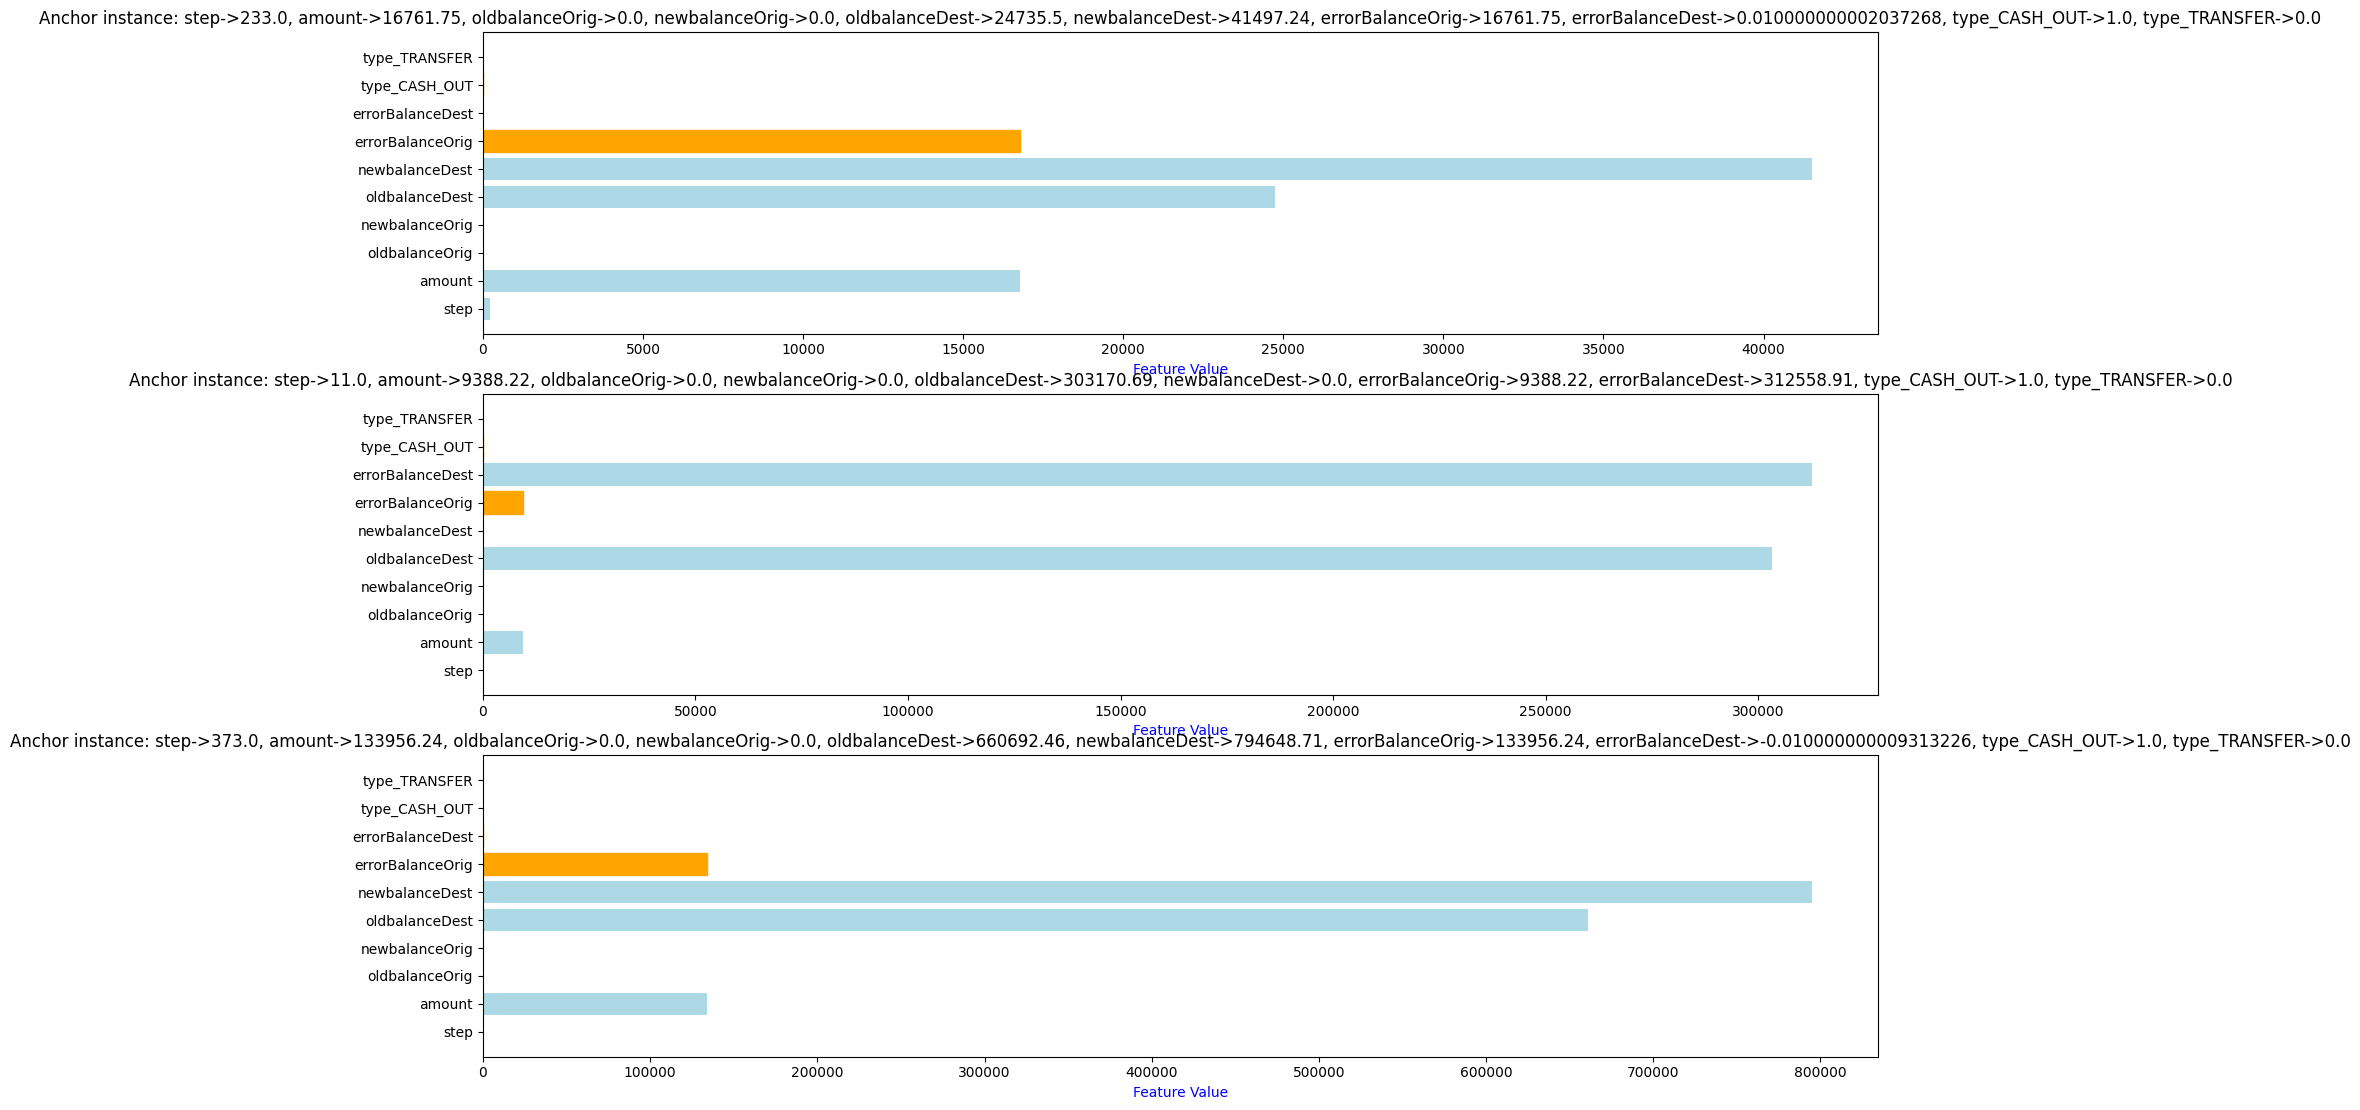

In [98]:
feature_names = x_test.columns.tolist()
n = len(anchor_explanations)
plt.figure(figsize=(n*6, n*6))
i = 1

for explanation, instance in zip(anchor_explanations, instances):
    print('Anchor:', explanation.anchor)
    print('Precision:', explanation.precision)
    print('Coverage:', explanation.coverage)
    print(f"The rule covers {explanation.coverage * 100:.2f}% of the test data, and within this region, the model prediction is {explanation.precision * 100:.2f}% accurate.\n")
    # print('instance: ', explanation.raw["instance"])

    # anchor_features = explanation.features
    anchor_conditions = explanation.anchor
    anchor_feature_indices = explanation.raw["feature"]

    plt.subplot(n+1,1,i)
    bars = plt.barh(np.arange(len(feature_names)), instance, color='lightblue')
    for feature in anchor_feature_indices:
        bars[feature].set_color('orange')
    
    plt.yticks(np.arange(len(feature_names)), feature_names)
    plt.xlabel('Feature Value', color="blue")
    title = ", ".join(["->".join([str(feat), str(val)]) for (feat,val) in zip(feature_names, explanation.raw["instance"])])
    # print(title)
    plt.title(f'Anchor instance: {title}')
    i += 1
plt.show()


4e. Global Surrogate XAI Model

In [100]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [101]:
x_train_predictions = loaded_best_xgb.predict(x_train)
x_test_predictions = loaded_best_xgb.predict(x_test)

In [102]:
surrogate_model = DecisionTreeClassifier(max_depth=4, random_state=42)
surrogate_model.fit(x_train, x_train_predictions)

train_accuracy = accuracy_score(x_train_predictions, surrogate_model.predict(x_train))
test_accuracy = accuracy_score(x_test_predictions, surrogate_model.predict(x_test))

print(f"Surrogate Model Train Accuracy: {train_accuracy:.4f}")
print(f"Surrogate Model Test Accuracy: {test_accuracy:.4f}")

Surrogate Model Train Accuracy: 1.0000
Surrogate Model Test Accuracy: 0.9994


In [103]:
feature_importances = pd.Series(surrogate_model.feature_importances_, index=x_train.columns).sort_values(ascending=False)
print("\nFeature Importance from Surrogate Model:\n", feature_importances)


Feature Importance from Surrogate Model:
 errorBalanceOrig    0.821285
newbalanceOrig      0.149198
errorBalanceDest    0.028593
newbalanceDest      0.000344
amount              0.000319
oldbalanceOrig      0.000261
step                0.000000
oldbalanceDest      0.000000
type_CASH_OUT       0.000000
type_TRANSFER       0.000000
dtype: float64


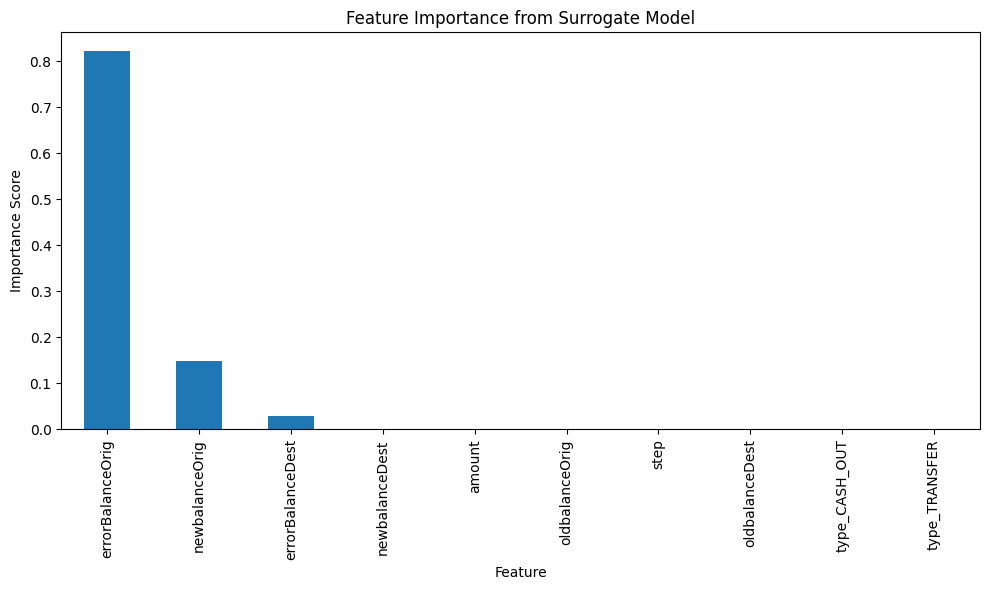

In [104]:
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title('Feature Importance from Surrogate Model')
plt.ylabel('Importance Score')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

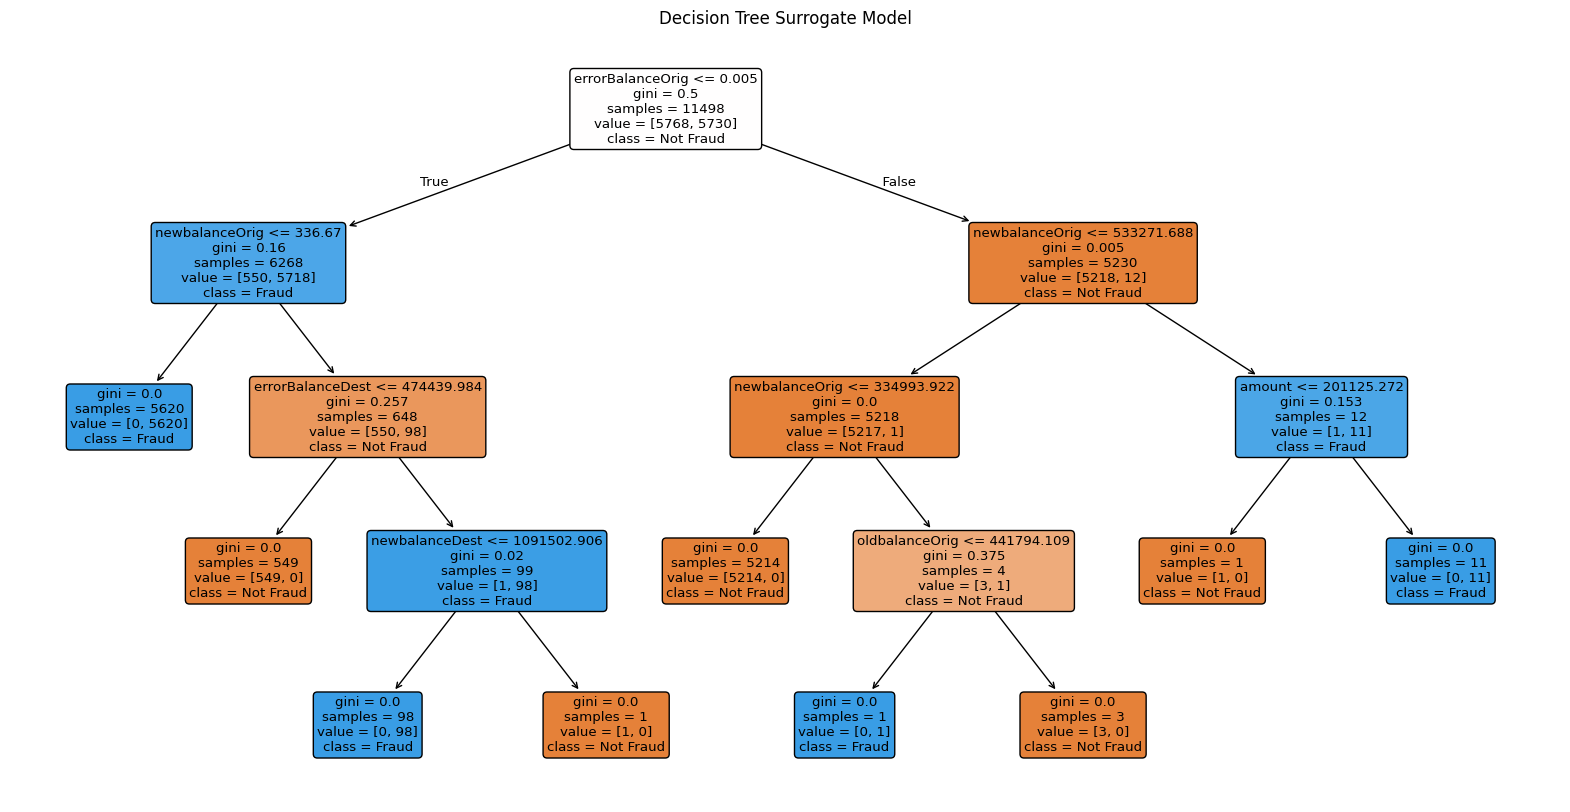

In [105]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(surrogate_model, feature_names=x_train.columns, class_names=['Not Fraud', 'Fraud'], filled=True, rounded=True)
plt.title("Decision Tree Surrogate Model")
plt.show()

4f. Explainable Boosting Classifier XAI Model

In [25]:
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

In [26]:
### Step 1: Train the Explainable Boosting Machine ###
ebm = ExplainableBoostingClassifier(random_state=42)
ebm.fit(x_train, y_train)

### Step 2: Evaluate EBM Performance ###
ebm_train_accuracy = ebm.score(x_train, y_train)
ebm_test_accuracy = ebm.score(x_test, y_test)

print(f"EBM Train Accuracy: {ebm_train_accuracy:.4f}")
print(f"EBM Test Accuracy: {ebm_test_accuracy:.4f}")


EBM Train Accuracy: 0.9989
EBM Test Accuracy: 0.9982



**Global Explanation of Feature Importance**
0.5944786124468155
0.3078135155797987
0.8821690024181723
1.104369599370955
0.4829571009643301
0.6005367292328617
5.089720648273976
0.8093928060140104
0.01790066108899008
0.01800970550892123
0.2628994393429786
0.07237353015697902
0.34920367985224127
0.14772608642057528
0.29245635754955873
1.2451146057571894
0.05032874629195318
0.050607266517020716
0.20055490788744468


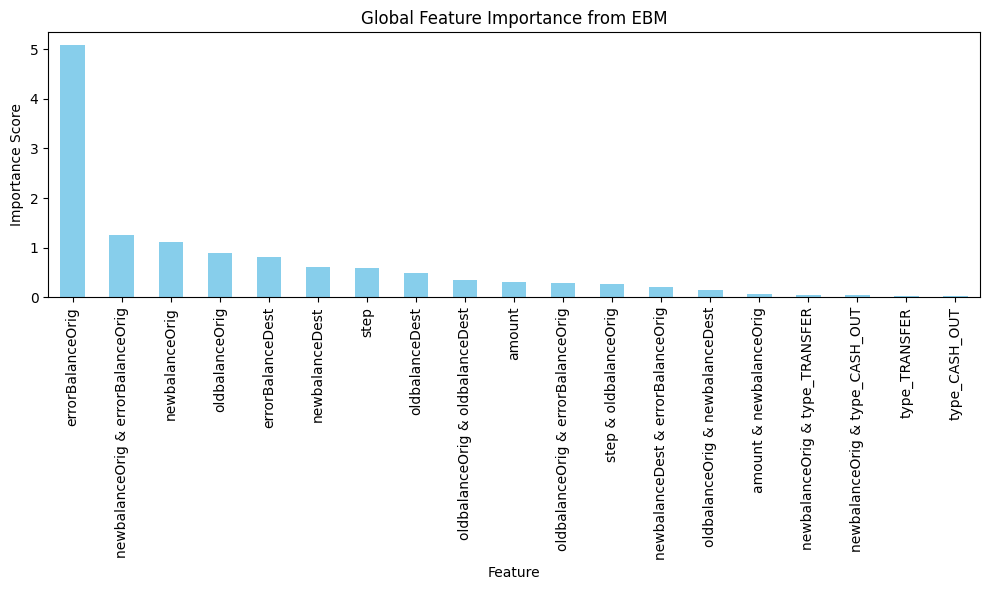

In [27]:
### Step 3: Global Explanation using EBM ###
# Display global feature importance using the EBM model
global_explanation = ebm.explain_global()
print("\n**Global Explanation of Feature Importance**")
for feature_importance in global_explanation.data()["scores"]:
    print(feature_importance)

# Plot the global feature importance
global_feature_importances = pd.Series(global_explanation.data()['scores'], index=global_explanation.feature_names).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
global_feature_importances.plot(kind='bar', color='skyblue')
plt.title('Global Feature Importance from EBM')
plt.ylabel('Importance Score')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

In [28]:
show(global_explanation)

<!-- http://127.0.0.1:7001/2439660786016/ -->


**Local Explanation for Instance 759**


<!-- http://127.0.0.1:7001/2439674855600/ -->


Comparing Feature Importances from EBM and XGBoost Model:


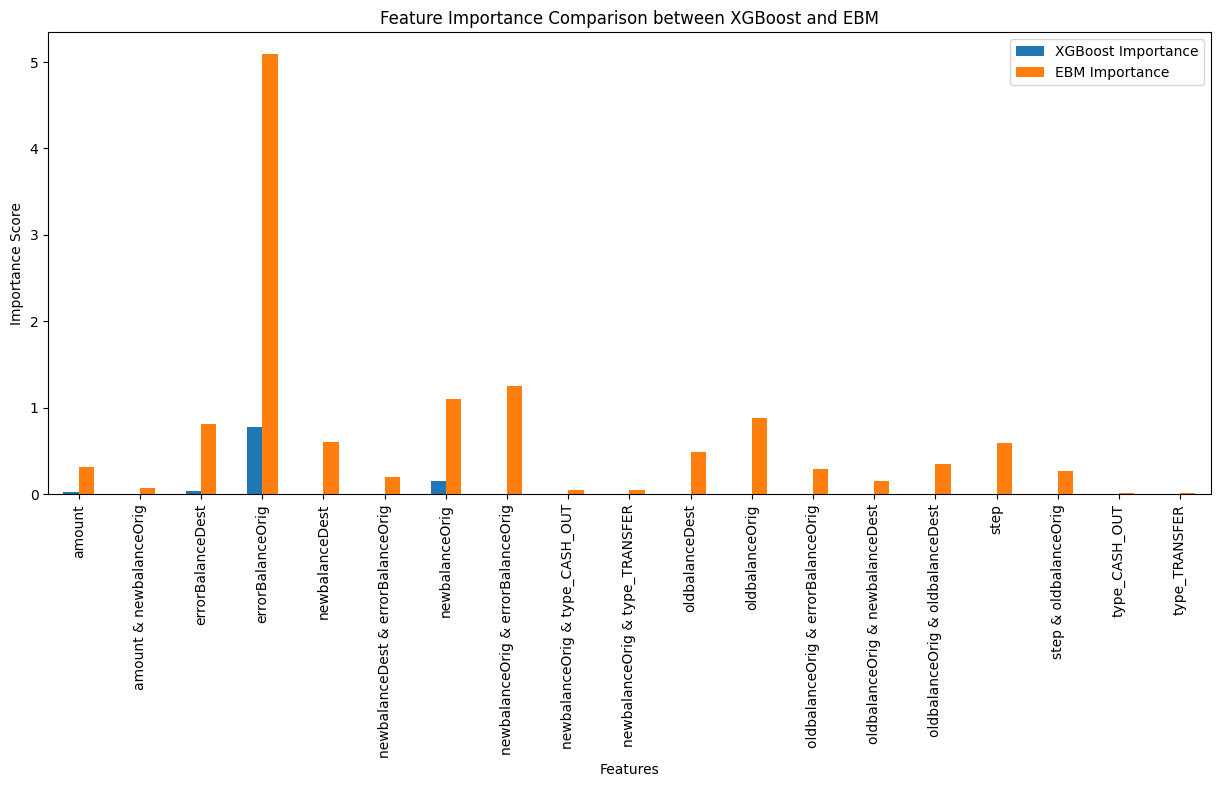

In [29]:
### Step 4: Local Explanation using EBM ###
# Select a test instance for local explanation
import random
instance_idx =  random.choice(np.arange(len(x_test))) # You can change this to explain other instances
local_explanation = ebm.explain_local(x_test.iloc[[instance_idx]], y_test.iloc[[instance_idx]])

print(f"\n**Local Explanation for Instance {instance_idx}**")
show(local_explanation, key=1)

### Additional Step: Compare EBM with XGBoost Model ###
# Feature importance comparison between XGBoost and EBM
print("\nComparing Feature Importances from EBM and XGBoost Model:")
xgb_feature_importance = pd.Series(loaded_best_xgb.feature_importances_, index=x_train.columns).sort_values(ascending=False)
ebm_feature_importance = pd.Series(global_explanation.data()['scores'], index=global_explanation.feature_names ).sort_values(ascending=False)

comparison_df = pd.DataFrame({
    'XGBoost Importance': xgb_feature_importance,
    'EBM Importance': ebm_feature_importance
})

comparison_df.plot(kind='bar', figsize=(15, 6), title='Feature Importance Comparison between XGBoost and EBM')
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.show()

# 5. XAI Model Metrics

5a. SHAP Metrics

In [119]:
from sklearn.metrics import r2_score

y_pred_original = loaded_best_xgb.predict(x_test)

explainer = shap.TreeExplainer(loaded_best_xgb)
shap_value = explainer.shap_values(x_test)
# SHAP values provide the contribution of each feature to the model's output.
# We need to reconstruct the predicted output from SHAP values
shap_pred = np.sum(shap_value, axis=1) + shap_explainer.expected_value

# Calculate fidelity
if len(np.unique(y_pred_original)) > 2:  # Regression case
    fidelity = r2_score(y_pred_original, shap_pred)
    print(f'Fidelity score of SHAP is: {1-fidelity}')
else:  # Classification case
    fidelity = accuracy_score(y_pred_original, np.round(shap_pred))
    print(f'Fidelity score of SHAP is: {1-fidelity}')

Fidelity score of SHAP is: 0.0006087662337662338


In [116]:
shap_feature_variance = np.var(shap_value, axis=0)
unambiguity = 1 / (1 + np.mean(shap_feature_variance))  # Higher variance means less unambiguous
print(f'Unambiguity of SHAP is: {unambiguity}')

Unambiguity of SHAP is: 0.23856443986638173


In [117]:
non_zero_features = np.sum(np.abs(shap_value) > 0, axis=1)
interpretability_size = np.mean(non_zero_features)
print(f'Interpretability size of SHAP is: {interpretability_size}')

Interpretability size of SHAP is: 9.0


5b LIME Metrics

In [89]:
lime_predictions = []
lime_feature_weights = []
# print(len(x_test))
for i in range(len(x_test)):
    # print(i)
    instance = x_test.iloc[i].values
    lime_exp = lime_explainer.explain_instance(instance, predict_function)
    
    # Get the LIME explanation's prediction
    lime_pred_class = np.argmax(lime_exp.predict_proba)
    lime_predictions.append(lime_pred_class)

    # Collect feature weights (converted to a dictionary for easier manipulation)
    feature_weights = dict(lime_exp.as_list())
    lime_feature_weights.append(feature_weights)

# Get the original model's predictions
model_predictions = loaded_best_xgb.predict(x_test)

# Calculate fidelity using accuracy score
lime_fidelity = accuracy_score(model_predictions, lime_predictions)
print(f"LIME Fidelity: {lime_fidelity}")

4928
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
2

In [90]:
# 2. Unambiguity Calculation
# Collect the feature weights from LIME explanations for multiple samples

# Calculate variance of weights for each feature across different instances
feature_names = x_test.columns
feature_variances = []

for feature in feature_names:
    weights = [fw.get(feature, 0) for fw in lime_feature_weights]  # Get weights, defaulting to 0 if feature wasn't used
    feature_variances.append(np.var(weights))

# Unambiguity score: Inverse of average variance (high variance means low unambiguity)
lime_unambiguity = 1 / (1 + np.mean(feature_variances))
print(f"LIME Unambiguity: {lime_unambiguity}")

LIME Unambiguity: 1.0


In [118]:
# 3. Interpretability Size Calculation
# Calculate the average number of features used in the LIME explanations
interpretability_sizes = [len([w for w in fw.values() if w != 0]) for fw in lime_feature_weights]
lime_interpretability_size = np.mean(interpretability_sizes)
print(f"LIME Interpretability size: {lime_interpretability_size}")

LIME Interpretability size: 10.0


In [99]:
def calculate_anchor_metrics(anchor_explanations, model, X_test):
    # Initialize lists to collect metrics
    fidelities = []
    unambiguities = []
    interpretability_sizes = []

    for explanation in anchor_explanations:
        # Calculate fidelity based on precision of anchor explanations
        fidelity = explanation.precision  # Already provided by Anchor
        fidelities.append(fidelity)

        # Calculate unambiguity as variance in precision (high variance means less unambiguous)
        unambiguities.append(1 / (1 + np.var([explanation.precision])))

        # Calculate interpretability size: number of features in the anchor
        interpretability_size = len(explanation.anchor)
        interpretability_sizes.append(interpretability_size)

    # Average metrics
    avg_fidelity = np.mean(fidelities)
    avg_unambiguity = np.mean(unambiguities)
    avg_interpretability_size = np.mean(interpretability_sizes)

    return avg_fidelity, avg_unambiguity, avg_interpretability_size

# Calculate metrics for the Anchor explanations
anchor_fidelity, anchor_unambiguity, anchor_interpretability_size = calculate_anchor_metrics(anchor_explanations, loaded_best_xgb, x_test)

print(f"Anchor Fidelity: {anchor_fidelity}")
print(f"Anchor Unambiguity: {anchor_unambiguity}")
print(f"Anchor Interpretability Size: {anchor_interpretability_size}")

Anchor Fidelity: 1.0
Anchor Unambiguity: 1.0
Anchor Interpretability Size: 2.0


In [111]:
def calculate_surrogate_metrics(original_model, surrogate_model, x_train, x_test, x_train_predictions, x_test_predictions):
    # 1. Fidelity Calculation
    surrogate_train_predictions = surrogate_model.predict(x_train)
    surrogate_test_predictions = surrogate_model.predict(x_test)

    train_fidelity = accuracy_score(x_train_predictions, surrogate_train_predictions)
    test_fidelity = accuracy_score(x_test_predictions, surrogate_test_predictions)

    avg_fidelity = (train_fidelity + test_fidelity) / 2

    # 2. Unambiguity Calculation
    feature_importances = pd.Series(surrogate_model.feature_importances_, index=x_train.columns)
    unambiguity_score = 1 / (1 + np.var(feature_importances))

    # 3. Interpretability Score Calculation
    # Interpretability can be based on the depth of the tree and number of nodes
    n_nodes = surrogate_model.tree_.node_count
    max_depth = surrogate_model.tree_.max_depth

    interpretability_score = n_nodes / max_depth  # Simpler measure of interpretability

    return avg_fidelity, unambiguity_score, interpretability_score

# Calculate metrics for the global surrogate model
surrogate_fidelity, surrogate_unambiguity, surrogate_interpretability = calculate_surrogate_metrics(
    loaded_best_xgb, surrogate_model, x_train, x_test, x_train_predictions, x_test_predictions
)

print(f"Surrogate Model Fidelity: {surrogate_fidelity:.4f}")
print(f"Surrogate Model Unambiguity: {surrogate_unambiguity:.4f}")
print(f"Surrogate Model Interpretability Score: {surrogate_interpretability:.4f}")

Surrogate Model Fidelity: 0.9997
Surrogate Model Unambiguity: 0.9436
Surrogate Model Interpretability Score: 4.2500


In [114]:
def calculate_ebm_metrics(ebm_model, x_train, x_test, y_train, y_test):
    # 1. Fidelity Calculation
    ebm_train_predictions = ebm_model.predict(x_train)
    ebm_test_predictions = ebm_model.predict(x_test)

    fidelity_train = accuracy_score(y_train, ebm_train_predictions)
    fidelity_test = accuracy_score(y_test, ebm_test_predictions)

    avg_fidelity = (fidelity_train + fidelity_test) / 2

    # 2. Unambiguity Calculation
    # Get the global explanation which includes feature importances
    global_explanation = ebm_model.explain_global()
    feature_importances = pd.Series(global_explanation.data()["scores"], index=global_explanation.feature_names)

    unambiguity_score = 1 / (1 + np.var(feature_importances))

    # 3. Interpretability Score Calculation
    # The interpretability of EBM can be quantified by the number of features it uses
    interpretability_score = len(feature_importances[feature_importances > 0])  # Number of features used

    return avg_fidelity, unambiguity_score, interpretability_score

# Calculate metrics for the Explainable Boosting Machine
ebm_fidelity, ebm_unambiguity, ebm_interpretability = calculate_ebm_metrics(
    ebm, x_train, x_test, y_train, y_test
)

print(f"EBM Fidelity: {ebm_fidelity:.4f}")
print(f"EBM Unambiguity: {ebm_unambiguity:.4f}")
print(f"EBM Interpretability Score: {ebm_interpretability:.4f}")

EBM Fidelity: 0.9985
EBM Unambiguity: 0.4505
EBM Interpretability Score: 19.0000


4d. Partial Dependency Plots

In [ ]:
# from sklearn.inspection import PartialDependenceDisplay, partial_dependence
# loaded_best_xgb.feature_names_in_
# features_to_analyse = ['amount', 'oldbalanceOrig', 'newbalanceOrig', 'errorBalanceOrig', 'step']
# # Generating PDPs for individual features
# for feature in features_to_analyse:
#     fig, ax = plt.subplots(figsize=(10, 6))
    
#     # Generate the PDP for the feature
#     display = PartialDependenceDisplay.from_estimator(
#         loaded_best_xgb,  # The XGBoost model you trained
#         X=x_test,         # Test set to base the PDP on
#         features=[feature],
#         ax=ax,
#         grid_resolution=50  # Resolution of the grid for PDP
#     )
    
#     # Adding titles and labels for interpretability
#     plt.title(f"Partial Dependence Plot for Feature: {feature}", fontsize=14)
#     plt.xlabel(f"Values of Feature: {feature}", fontsize=12)
#     plt.ylabel("Partial Dependence", fontsize=12)
#     plt.grid(True, linestyle='--', alpha=0.7)
    
#     # Annotations for interpreting key values
#     mean_value = x_test[feature].mean()
#     plt.axvline(mean_value, color='red', linestyle='--', label=f'Mean Value: {mean_value:.2f}')
#     plt.legend()
    
#     # Interpretation message for guidance
#     print(f"\n** Interpretation for PDP of '{feature}': **")
#     print(f"1. Observe how the predicted probability varies as '{feature}' changes.")
#     print(f"2. The vertical red line indicates the average value of '{feature}' in the test set.")
#     print(f"3. The shape of the plot shows whether there's a linear, non-linear, or threshold relationship.\n")
#     plt.show()

# from itertools import combinations
# interaction_features = list(combinations(features_to_analyse, 2))

# for feature_pair in interaction_features:
#     fig, ax = plt.subplots(figsize=(12, 8))
    
#     # Generate the PDP for the feature pair
#     display = PartialDependenceDisplay.from_estimator(
#         loaded_best_xgb,
#         X=x_test,
#         features=[feature_pair],
#         ax=ax,
#         grid_resolution=30
#     )
    
#     # Adding titles and labels for interpretability
#     plt.title(f"2D Partial Dependence Plot for Interaction: {feature_pair}", fontsize=14)
#     plt.xlabel(f"Values of Feature: {feature_pair[0]}", fontsize=12)
#     plt.ylabel(f"Values of Feature: {feature_pair[1]}", fontsize=12)
    
#     # Adding interpretation messages for the 2D plot
#     print(f"\n** Interpretation for 2D PDP between '{feature_pair[0]}' and '{feature_pair[1]}': **")
#     print(f"1. This plot shows how the interaction between '{feature_pair[0]}' and '{feature_pair[1]}' affects the model's predictions.")
#     print(f"2. Look for regions where the surface is flat (no interaction) versus areas with peaks/valleys (strong interaction).")
#     print(f"3. This insight can help identify if the combination of these features plays a significant role in predicting fraud.\n")
#     plt.show()
